<a href="https://colab.research.google.com/github/kuzhuppillil/Current_Project/blob/main/ValueInvestor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Value Investor:**

Our goal is to establish a robust intelligent system to aid our value investing efforts using stock market data.


 **Objective:** Predict stock price valuations on a daily, weekly and monthly basis. Recommend BUY, HOLD, SELL decisions. Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.


In [1]:
pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.6 MB/s eta 0:00:00


In [2]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf

from statsmodels.tsa.holtwinters import ExponentialSmoothing

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tseries.offsets import DateOffset

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import keras.backend as K

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

In [4]:
#reading and saving each stock data into a dictionary
file_path = "/content/drive/Othercomputers/My Laptop/Apziva Projects/ValueInvestor/2020Q1Q2Q3Q4-2021Q1.xlsx"

sheets = pd.ExcelFile(file_path)

df_dic = {}

for sheet_name in sheets.sheet_names:
  df = pd.read_excel(file_path,sheet_name = sheet_name, index_col="Date", parse_dates=["Date"])
  df_dic[sheet_name] = df

# Preprocessing:

In [5]:
#Function to preprocess data
def ini_preprocess(df):
  #Removing the last row from df
  df = df.iloc[:-1].copy()

  #converting to float datatype and removing strings
  df['Vol.'] = df['Vol.'].str.replace('M', 'e6').str.replace('K', 'e3').str.replace('-', '0').astype(float)
  df = df.astype(float)

  #fixing datatime index
  df.index = pd.to_datetime(df.index)
  df = df.sort_index()
  df.info()
  print(df.tail())
  return df

# EDA:

In [6]:
#Ploting linechat to vizualize the stock price variation

def EDA_plot(df,name):
  plt.figure(figsize=(18,8))
  plt.fill_between(df.index, df['Low'], df['High'], alpha=0.3, label = " Low/High")
  plt.plot(df['Price'], linewidth=1, label = "Closing Price")
  plt.title(f"Linechart - Price Plot: {name}")
  plt.legend()
  plt.show()
  mpl_plot(df,name)

#Plotting candlechart using mplfinance
def mpl_plot(df,name):
  df2 = df.copy()
  df2.rename(columns={'Price': 'Close'}, inplace=True)
  print("\n")
  mpf.plot(df2, type='candle', style='charles',title=f'Candlestick Chart - Price Plot: {name}', figsize = (20,9))

#Exponential Smoothing Forecast

In [7]:
def ES_Forecasting(df,name):

    #fixing indexing for ExponentialSmoothing
    train_ES = df.loc['2020',['Price']].copy()
    df_ES = df.reset_index().copy()
    test_ES = df_ES[df_ES['Date'].dt.year == 2021].copy()

    # Forecasting price using exponential smoothing with statsmodels
    model_ES = ExponentialSmoothing(train_ES['Price'], trend='add')
    fit_model = model_ES.fit()
    forecast = fit_model.forecast(steps=len(test_ES))

    test_ES['Forecast'] = forecast
    test_ES['APE'] = np.abs((test_ES['Price'] - test_ES['Forecast']) / test_ES['Price']) * 100
    mape_forecast = np.mean(test_ES['APE'])
    print(f"Exponential Smoothing Forecast MAPE: {mape_forecast:.2f}%")

    print(fit_model.summary())
    print("Estimated Parameters:")
    print(fit_model.params)

    test_ES.index = pd.to_datetime(test_ES['Date'])

    # Plotting
    plt.figure(figsize=(14, 6))
    # plt.plot(train_ES.index, train_ES['Price'], label='Training Data')
    plt.plot(test_ES.index, test_ES['Price'], label='Actual Prices')
    plt.plot(test_ES.index, test_ES['Forecast'], label='Exponential Smoothing Forecast')
    plt.title(f'Actual Price vs Forecast : {name}')
    plt.legend()
    plt.show()

    return test_ES, fit_model


# Forecasting using PROPHET

In [8]:
def FB_Prop_Forecast(df,name):

    #train-test split, using 2020 Q1,Q2,Q3,Q4 data for training and 2020 Q1 for test
    train_FP = df.loc['2020',['Price']].copy()
    test_FP = df.loc['2021'].copy()

    #Data preprocessing for PROPHET
    train_FP.reset_index(inplace=True)
    train_FP.rename(columns = {'Date':'ds','Price':'y'}, inplace=True)
    test_FP.reset_index(inplace=True)

    #model fitting
    model_FP = Prophet(yearly_seasonality=False,weekly_seasonality=False,seasonality_prior_scale=0.1)
    model_FP.fit(train_FP)

    #forecasting
    future_FP = model_FP.make_future_dataframe(periods=90)
    forecast_FP = model_FP.predict(future_FP)

    #ploting the forecast
    fig1 = model_FP.plot(forecast_FP)

    #merging predicted df with actual df
    merged_forecast = pd.merge(forecast_FP,test_FP,left_on='ds',right_on='Date',how = 'right')

    # Calculating MAPE
    merged_forecast['MAPE'] = abs((merged_forecast['Price'] - merged_forecast['yhat']) / merged_forecast['Price']) * 100
    mape = merged_forecast['MAPE'].mean()
    print(f"\n\nMean Absolute Percentage Error (MAPE): {mape:.2f}%")

    #ploting forecast with comparison to actuals
    plt.figure(figsize=(10,5))
    plt.fill_between(merged_forecast['ds'], merged_forecast['Low'], merged_forecast['High'], alpha=0.3, label = " Low/High")
    plt.fill_between(merged_forecast['ds'], merged_forecast['yhat_lower'], merged_forecast['yhat_upper'], alpha=0.3, label = " Forecasted - Low/High")
    plt.plot(merged_forecast['ds'],merged_forecast['Price'],label='Actual Price',color ='blue')
    plt.plot(merged_forecast['ds'],merged_forecast['yhat'],label='Predicted Price',color ='red')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Actuals vz PROPHET Predictions : {name}')
    plt.legend()
    plt.show()

    return model_FP, forecast_FP


In [9]:
  # plot_plotly(model_FP, forecast_FP)
  # plot_components_plotly(model_FP, forecast_FP)

# Forecasting using ARIMA

In [10]:

def ARIMA_prerun(df):

    #preprocessing the dataset for ARIMA model
    train_ARIMA = df.loc['2020', ['Price']].copy()
    test_ARIMA = df.loc['2021', ['Price']].copy()

    train_index = train_ARIMA.index
    forecast_index = test_ARIMA.index

    train_ARIMA.reset_index(drop=True,inplace=True)
    test_ARIMA.reset_index(drop=True,inplace=True)

    #Creating continous index range with day frequency
    train_ARIMA.index = pd.date_range(start='2020-01-03', periods=len(train_ARIMA), freq='D')
    test_ARIMA.index = pd.date_range(start=train_ARIMA.index[-1]+pd.Timedelta(days=1), periods=len(test_ARIMA), freq='D')

    #dickey fuller test
    dftest = adfuller(train_ARIMA['Price'])
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    labels = ['Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(dftest,labels):
      print(label+' : '+str(value) )
    if (pvalue < 0.05) and (adf < critical_value):
      print('The series is stationary')
    else:
      print('The series is NOT stationary')

    results_1 = seasonal_decompose(train_ARIMA['Price'], model = 'additive')
    fig = plt.figure()
    fig = results_1.plot()
    fig.set_size_inches(8, 6)
    fig.show()

    return train_ARIMA, test_ARIMA, train_index, forecast_index




def ARIMA_forecast(train_ARIMA, test_ARIMA, train_index, forecast_index,name):

    #auto arima model
    ARIMA_model = auto_arima(train_ARIMA['Price'],
                          start_p=0,
                          start_q=0,
                          test='adf',
                          max_p=3, max_q=3,
                          m=1,
                          d=None,
                          seasonal=False,
                          trace=False,
                          error_action='warn',
                          suppress_warnings=True,
                          stepwise=True)
    print("ARIMA Order:",ARIMA_model.order)

    # Forecast
    n_periods = len(test_ARIMA)
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(train_ARIMA.index[-1]+pd.Timedelta(days=1), periods =n_periods, freq='D')

    forecast_df = pd.DataFrame({'Fitted': fitted,'Lower': confint[:, 0],'Upper': confint[:, 1]}, index=index_of_fc)

    # Calculate MAPE for each forecast point
    forecast_df['MAPE'] = abs((test_ARIMA['Price'] - forecast_df['Fitted']) / test_ARIMA['Price']) * 100
    mape = forecast_df['MAPE'].mean()
    print(f"\n\nMean Absolute Percentage Error (MAPE): {mape:.2f}%")

    test_ARIMA.index = forecast_index
    train_ARIMA.index = train_index
    forecast_df.reset_index(drop = True,inplace = True)
    forecast_df.index = forecast_index

    # Plotting
    plt.figure(figsize=(15, 7))
    # plt.plot(train_ARIMA["Price"], color='Blue', label="Historic Price")
    plt.plot(test_ARIMA["Price"], color='Green', label="Actual Price")
    plt.plot(forecast_df['Fitted'], color='red', label="Forecast")
    plt.fill_between(forecast_df.index,
                    forecast_df['Lower'],
                    forecast_df['Upper'],
                    color='k', alpha=.15, label="Forecast - Low/High")

    plt.title(f"ARIMA - Forecast of Stock : {name}")
    plt.legend()
    plt.show()

    return ARIMA_model,forecast_df

# Forecasting with LSTM

In [11]:
K.clear_session()
scaler =  MinMaxScaler()

#prepraing the data for LSTM model

def df_to_X_y(df, window_size):
  X = []
  y = []
  for i in range(len(df)-window_size):
    row = df[i:i+window_size]
    X.append(row)
    label = df[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)


#bulding and training LSTM model

def lstm(df,name):

    window_size = 5

    #scaling the datasent
    scaled = scaler.fit_transform(df[['Price']])
    # test_LSTM_scaled = scaler.transform(df.loc['2021',['Price']])

    #converting to tensors
    X1, y1, = df_to_X_y(scaled,window_size)
    # X_test, y_test = df_to_X_y(test_LSTM_scaled,window_size)

    #spliting train and val set
    # train_len = len(df[df.index.year == 2020])
    # val_len = int((1-.2) * train_len)
    # test_len = len(df[df.index.year == 2021])

    train_len = len(df[df.index.year == 2020]) - window_size
    val_len = int((1 - 0.2) * train_len)
    # test_len = len(df[df.index.year == 2021])

    X_train, y_train = X1[:val_len], y1[:val_len]
    X_val, y_val = X1[val_len:train_len], y1[val_len:train_len]
    X_test, y_test = X1[train_len:], y1[train_len:]



    #shapes
    print("scaled price dataset",scaled.shape)
    print("scaled tensor",X1.shape, y1.shape)
    print("training",X_train.shape, y_train.shape)
    print("validation",X_val.shape, y_val.shape)
    print("test",X_test.shape, y_test.shape)

    #bulding the LSTM model
    model_lstm = Sequential()
    model_lstm.add(InputLayer((5, 1)))
    model_lstm.add(LSTM(64))
    model_lstm.add(Dense(1, 'linear'))
    model_lstm.summary()

    model_lstm.compile(loss=MeanSquaredError(), optimizer='adam', metrics=[RootMeanSquaredError()])

    cp = ModelCheckpoint('model_lstm/', save_best_only=True)

    #model fitting
    model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp])

    #recalling the best model
    model_lstm_best = load_model('model_lstm/')

    #forecast
    test_predictions = model_lstm_best.predict(X_test).flatten()

    # Inverse transform to the original scale
    y_test_original_scale = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    predictions_original_scale = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

    original_index = df.loc['2021', 'Price'].index

    test_results = pd.DataFrame(data={'Test_Predictions': predictions_original_scale, 'Actuals': y_test_original_scale}, index=original_index)
    test_results.index = pd.to_datetime(test_results.index)

    test_results['APE'] = np.abs((test_results['Actuals'] - test_results['Test_Predictions']) / test_results['Actuals']) * 100
    mape_forecast = np.mean(test_results['APE'])
    print(f"MAPE: {mape_forecast:.2f}%")

    # Plotting
    plt.figure(figsize=(15, 7))
    plt.plot(test_results['Actuals'], color='Green', label="Actual Price")
    plt.plot(test_results['Test_Predictions'], color='red', label="Forecast")
    plt.title(f"LSTM - Forecast of Stock : {name}")
    plt.legend()
    plt.show()

    return model_lstm_best,test_results


In [12]:
#model_lstm_best.save("/content/drive/Othercomputers/My Laptop/Apziva Projects/ValueInvestor/model_lstm_best")

# Trading Algorithm

In [13]:
def calculate_bollinger_bands(forecast_price, window, num_std=2):

    # Calculate the moving average (MA) and standard deviation (σ)
    ma = forecast_price.rolling(window=window).mean()
    std = forecast_price.rolling(window=window).std()

    # Calculate Upper and Lower Bollinger Bands
    UB = ma + num_std * std
    LB = ma - num_std * std

    # #volatility indicator calculation
    # bandwidth = (UB - LB) / UB
    # mean_bandwidth = np.mean(bandwidth)

    # # Calculate standard deviation of bandwidth
    # std_bandwidth = np.std(bandwidth)
    # # Calculating threshold
    # threshold = mean_bandwidth - (num_std * std_bandwidth)

    # storing the results in new df
    bollinger_bands = pd.DataFrame({
        'MA': ma,
        'UB': UB,
        'LB': LB,
    })

    return bollinger_bands

In [14]:
def trading_algo(rolling_window,forecast,stoploss,initial_capital,LB_threshold,max_hold,min_margin,name):

    bollinger_bands = calculate_bollinger_bands(forecast['Test_Predictions'],window = rolling_window)
    df = pd.merge(forecast, bollinger_bands, on='Date', how='inner')

    running_capital = last_returns = initial_capital
    hold_counter = 0
    stocks = 0
    prev = []
    lower_band = []

    # DataFrame to store signals
    signals_df = pd.DataFrame(index=df.index, columns=['Buy', 'Sell', 'Hold'])

    for i in range(len(df)):
        current_price = df.iloc[i]['Actuals']
        index = df.index[i]
        upper_band = df.iloc[i]['UB']
        lower_band.append(df.iloc[i]['LB'])
        prev.append(current_price)

        #additional thresholds, range around band
        condition_above = current_price <= (1 + LB_threshold) * lower_band[-1]
        # condition_below = current_price >= (1 - LB_threshold) * lower_band[-1]
        # nearLB = (1 - 0.05) * lower_band

        if len(prev) > 1:
          if stocks == 0 and running_capital != 0:
              # BUY signal
              if (prev[-2] < lower_band[-2]) and (condition_above): #condition to assess potential upward trend for buying, trend around lowerband
                  stocks = running_capital / current_price
                  signals_df.at[index, 'Buy'] = current_price
                  running_capital = 0
                  print(f'{index}: Buy {stocks:.2f} stocks @ {current_price:.2f}')
                  stop_loss_price = current_price
                  locked_price = current_price #for profit condition
          elif stocks > 0:
              # update stoploss mark
              if current_price > stop_loss_price:
                  stop_loss_price = current_price
              # Stop loss trigger
              if current_price < (1 - stoploss) * stop_loss_price: #overrides profit conditions incase of loss, ensures minimized loss
                  running_capital += stocks * current_price
                  stocks = 0
                  stop_loss_price = 0
                  signals_df.at[index, 'Sell'] = current_price
                  print(f'{index}: Stoploss trigger: Sell @ {current_price:.2f}')
                  diff = running_capital-initial_capital
                  print(f'Estimated Returns:{running_capital:.2f}, Estimated Gain/Loss:{diff:.2f}')
                  if running_capital != initial_capital:
                    last_returns = running_capital
              # SELL signal for profit
              elif (current_price > upper_band and current_price > ((1+min_margin)*locked_price)) or (hold_counter >= max_hold and current_price > ((1+min_margin)*locked_price)): #condition to minimize hold period and maximize returns
                  running_capital += stocks * current_price
                  stocks = 0
                  stop_loss_price = 0
                  signals_df.at[index, 'Sell'] = current_price
                  print(f'{index}: Sell @ {current_price}')
                  profit = running_capital-initial_capital
                  print(f'Estimated Returns:{running_capital:.2f}, Estimated Gain/Loss:{profit:.2f}')
                  if running_capital != initial_capital:
                    last_returns = running_capital
              # HOLD
              else:
                  signals_df.at[index, 'Hold'] = current_price
                  hold_counter +=1
                  print(f'{index}: Hold stocks')


    return_per = ((last_returns-initial_capital)/initial_capital)*100
    print(f"Return of capital is {return_per:.1f}%")
    plot_signals(df, signals_df,name)



def plot_signals(df,signals_df,name):
      plt.figure(figsize=(15, 7))
      plt.plot(df['Test_Predictions'], color='Red', label='Predicted Price')
      plt.plot(df['Actuals'], color='blue', label='Actual Price')
      plt.plot(df['MA'], color='Orange', label='Moving Averge')
      plt.fill_between(df.index,df['UB'], df['LB'], alpha=0.3, label = "Bollinger - Upper and lower bands")

      # Scatter markers for Buy, Sell, and Hold signals
      plt.scatter(signals_df.index, signals_df['Buy'], color='green', marker='^',s=200, label='Buy Signal')
      plt.scatter(signals_df.index, signals_df['Sell'], color='red', marker='v',s=200, label='Sell Signal')

      plt.title(f"Stock Forecast of {name}")
      plt.legend()
      plt.show()

In [18]:
company_name = list(df_dic.keys())

for i in range(len(company_name)):
      print(f"{i} {company_name[i]}")


0 Russia - Sberbank Rossii PAO (S
1 Turkey - Koc Holding AS (KCHOL)
2 Egypt - Medinet Nasr Housing (M
3 Brazil - Minerva SABrazil (BEEF
4 Argentina - Pampa Energia SA (P
5 Colombia - Cementos Argos SA (C
6 South Africa - Impala Platinum 
7 South Korea - Dongkuk Steel Mil


# **Russia** - Sberbank

In [147]:
df_dic[company_name[0]].info()
print(df_dic[company_name[0]].tail())

<class 'pandas.core.frame.DataFrame'>
Index: 312 entries, 2021-03-31 00:00:00 to Highest: 296.07
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     312 non-null    object 
 1   Open      312 non-null    object 
 2   High      312 non-null    object 
 3   Low       312 non-null    object 
 4   Vol.      311 non-null    object 
 5   Change %  311 non-null    float64
dtypes: float64(1), object(5)
memory usage: 17.1+ KB
                              Price                Open             High  \
Date                                                                       
2020-01-09 00:00:00          257.99               259.4           261.76   
2020-01-08 00:00:00          259.15              253.57           259.15   
2020-01-06 00:00:00           253.9              254.75           254.84   
2020-01-03 00:00:00             255              255.99           258.19   
Highest: 296.07      Lowest: 172.15  Difference: 1

In [17]:
df_rus = ini_preprocess(df_dic[company_name[0]])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2020-01-03 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    float64
 2   High      311 non-null    float64
 3   Low       311 non-null    float64
 4   Vol.      311 non-null    float64
 5   Change %  311 non-null    float64
dtypes: float64(6)
memory usage: 17.0 KB
             Price    Open    High     Low        Vol.  Change %
Date                                                            
2021-03-25  286.66  286.50  287.03  283.85  35220000.0    0.0030
2021-03-26  291.22  288.63  292.75  288.32  56070000.0    0.0159
2021-03-29  293.30  289.72  294.09  289.26  43680000.0    0.0071
2021-03-30  293.25  294.86  295.72  291.50  38810000.0   -0.0002
2021-03-31  291.02  294.00  294.42  290.26  47000000.0   -0.0076


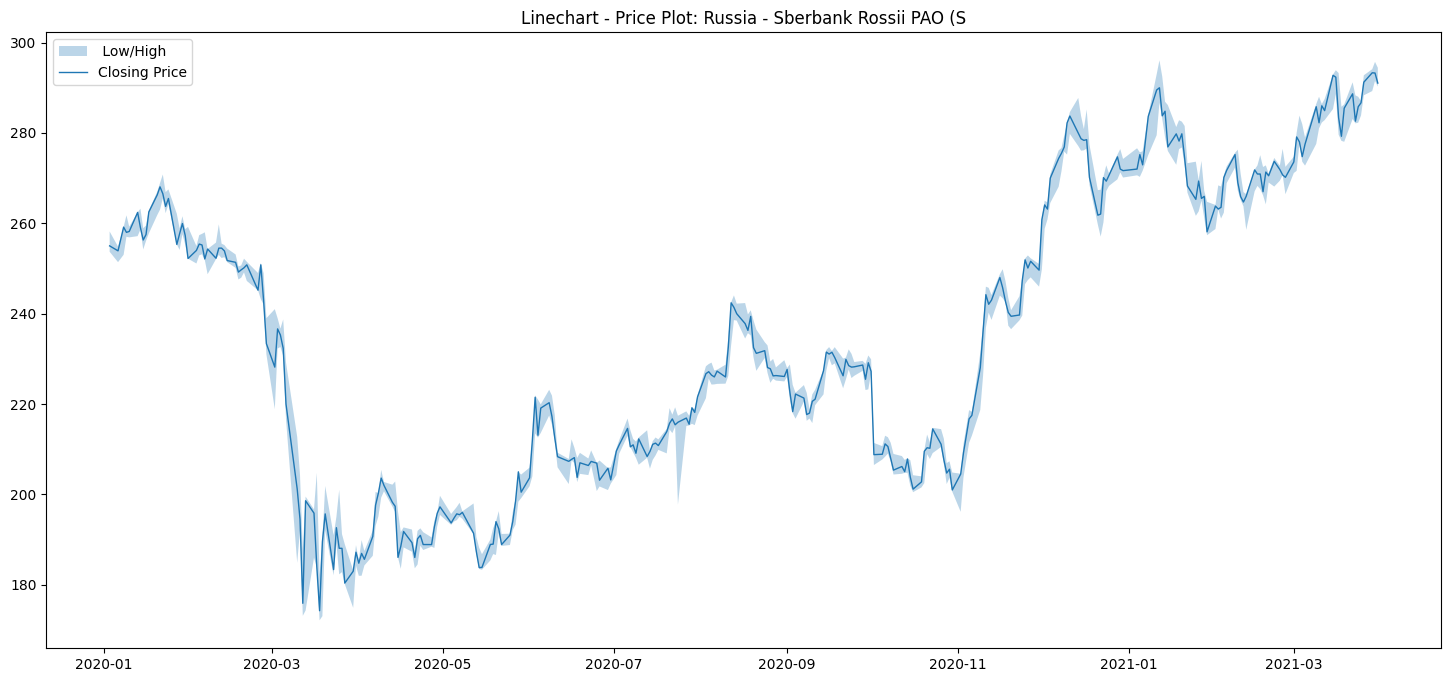

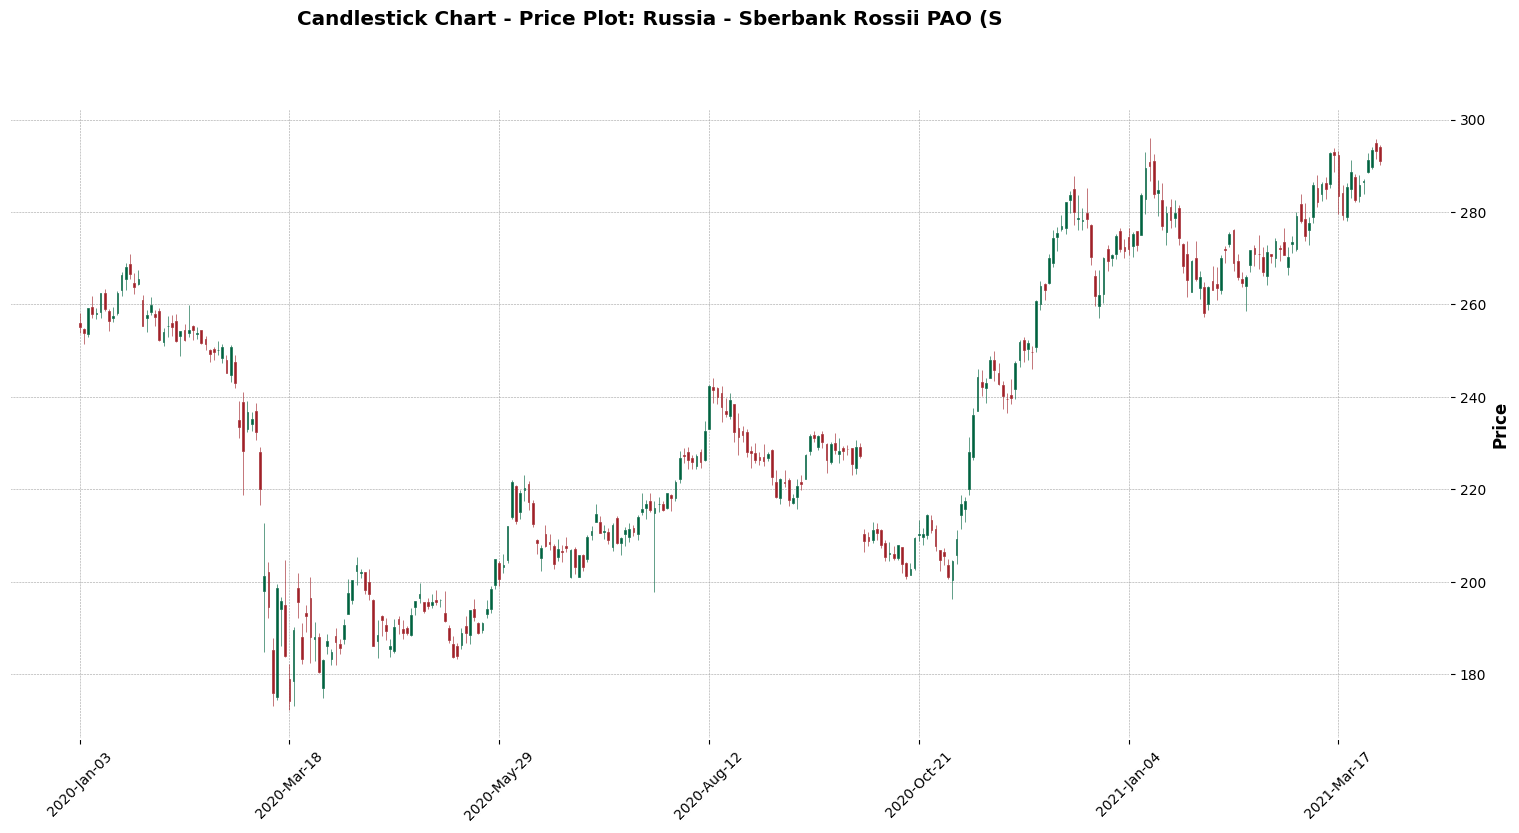

In [18]:
EDA_plot(df_rus,name =company_name[0])

Exponential Smoothing Forecast MAPE: 2.69%
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                  250
Model:             ExponentialSmoothing   SSE                           5920.371
Optimized:                         True   AIC                            799.173
Trend:                         Additive   BIC                            813.259
Seasonal:                          None   AICC                           799.519
Seasonal Periods:                  None   Date:                 Sun, 28 Jan 2024
Box-Cox:                          False   Time:                         16:01:29
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha             

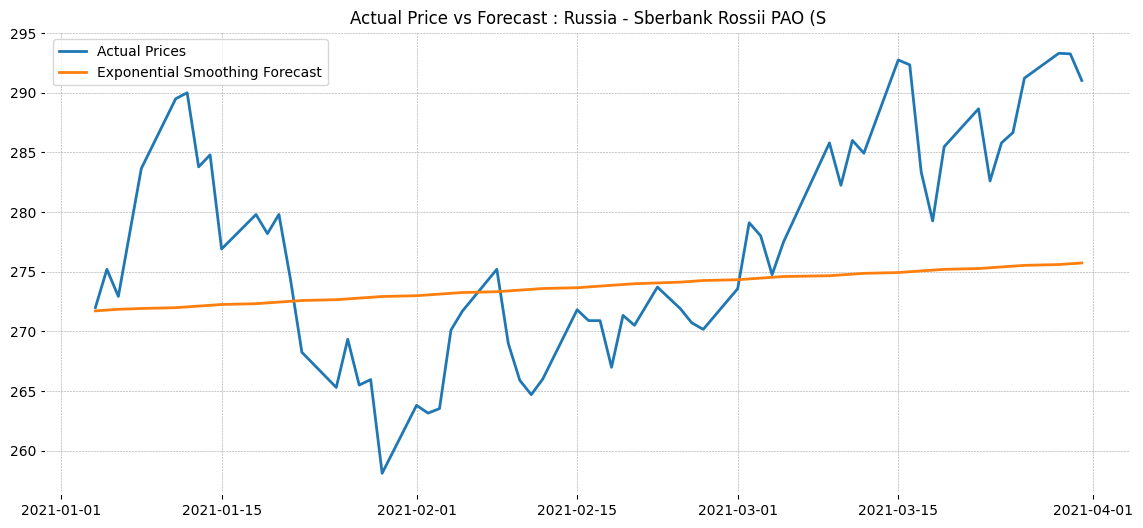

In [19]:
forecast_ES, model_ES = ES_Forecasting(df_rus,name=company_name[0])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr1ists4g/q9_l00_y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr1ists4g/r2f3binl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30480', 'data', 'file=/tmp/tmpr1ists4g/q9_l00_y.json', 'init=/tmp/tmpr1ists4g/r2f3binl.json', 'output', 'file=/tmp/tmpr1ists4g/prophet_modelfi2bwdr8/prophet_model-20240128160131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:01:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:01:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing




Mean Absolute Percentage Error (MAPE): 16.83%


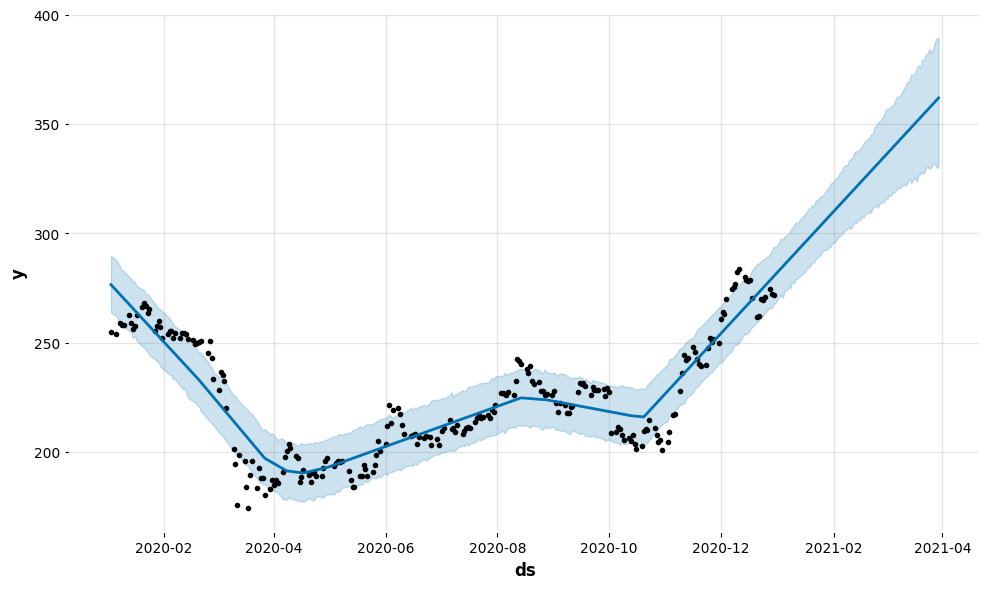

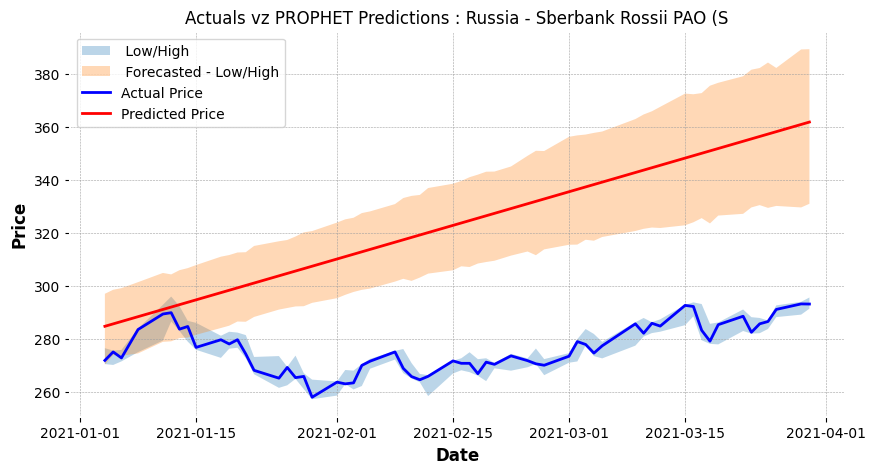

In [20]:
model_FP,forecast_FP = FB_Prop_Forecast(df_rus,name =company_name[0])

Test Statistic : -1.4233235279675995
p-value : 0.5710448680935888
#Lags Used : 8
Number of Observations Used : 241
The series is NOT stationary
ARIMA Order: (0, 1, 0)


Mean Absolute Percentage Error (MAPE): 2.91%


<Figure size 640x480 with 0 Axes>

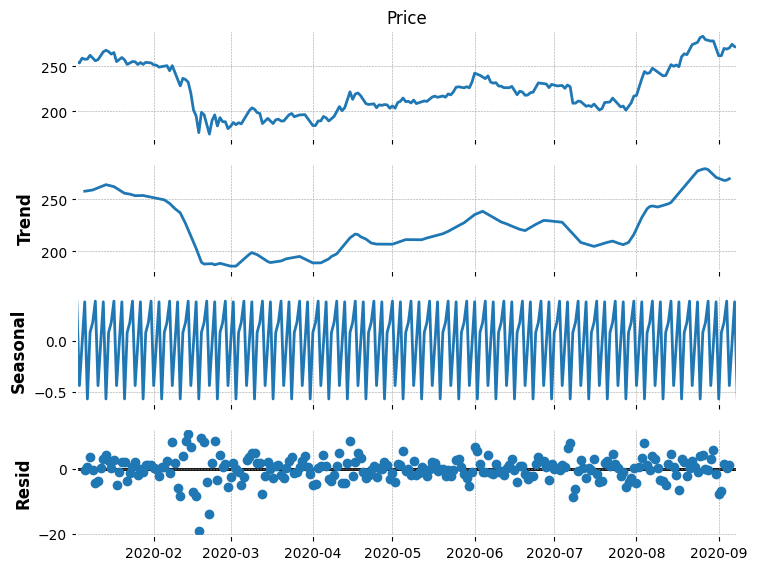

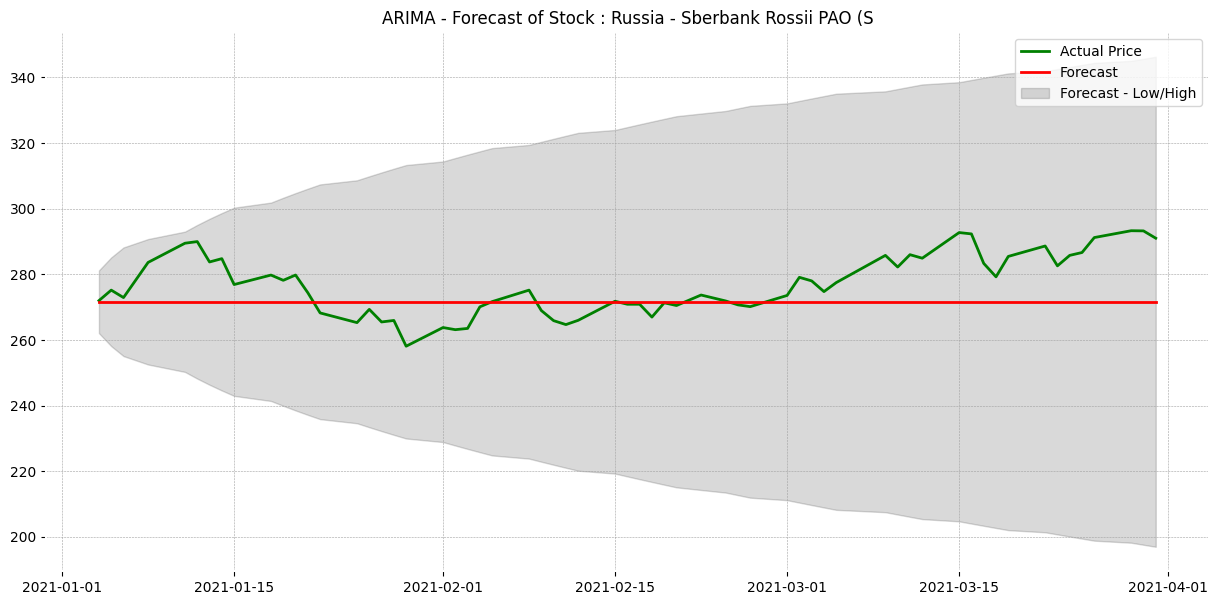

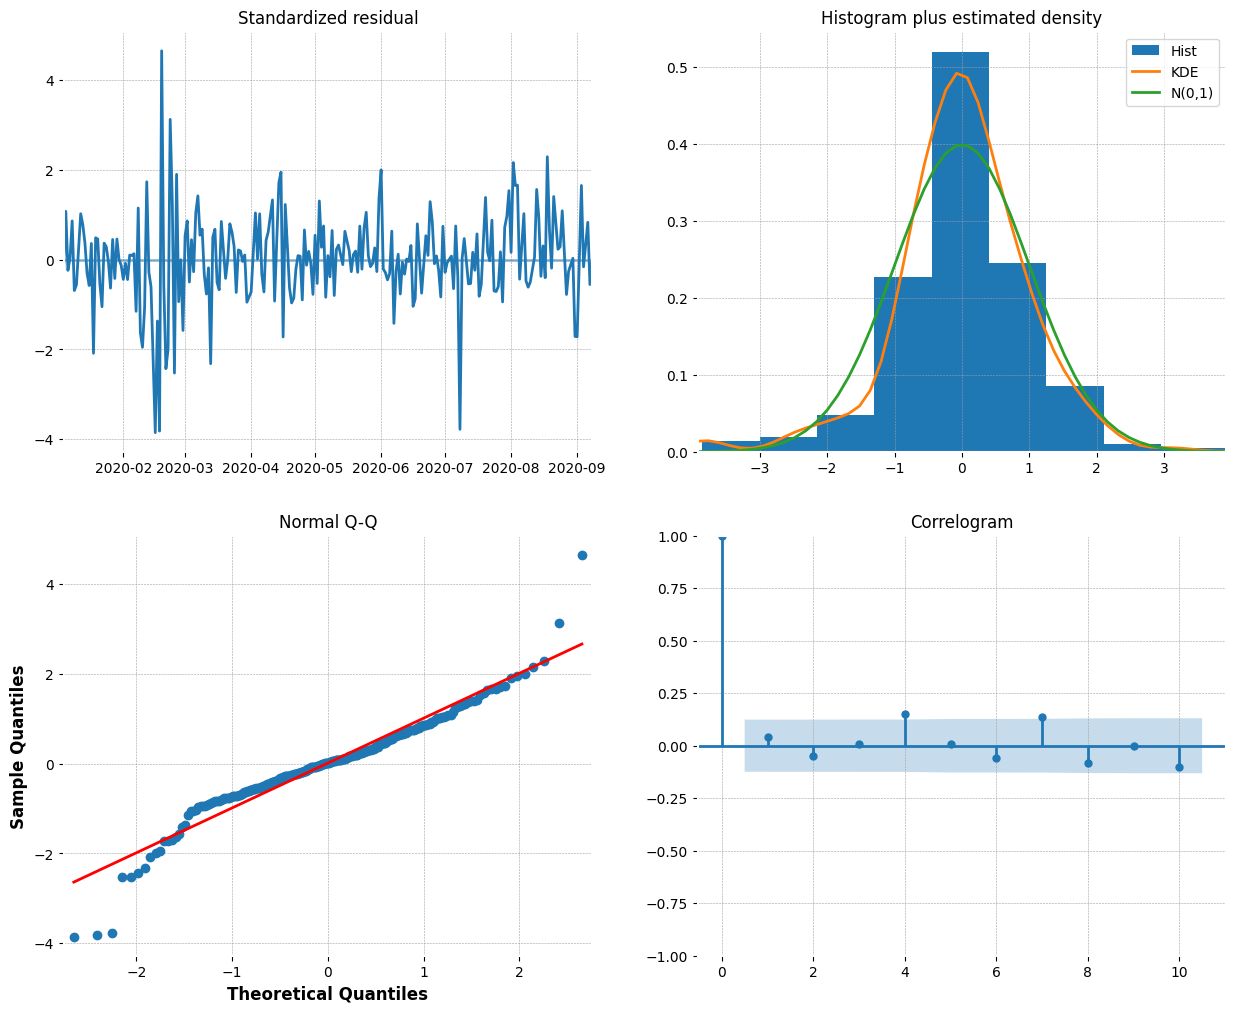

In [21]:
#arima prerun(ADFS test, data preprocessing)
train_ARIMA, test_ARIMA, train_index, forecast_index = ARIMA_prerun(df_rus)

ARIMA_model,forecast_df = ARIMA_forecast(train_ARIMA, test_ARIMA, train_index, forecast_index,name=company_name[0])

ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

scaled price dataset (311, 1)
scaled tensor (306, 5, 1) (306, 1)
training (196, 5, 1) (196, 1)
validation (49, 5, 1) (49, 1)
test (61, 5, 1) (61, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
7/7 [==============================] - 16s 2s/step - loss: 0.1548 - root_mean_squared_error: 0.3935 - val_loss: 0.2746 - val_root_mean_squared_error: 0.5240
Epoch 2/50
7/7 [==============================] - 3s 581ms/step - loss: 0.0648 - root_mean_squared_

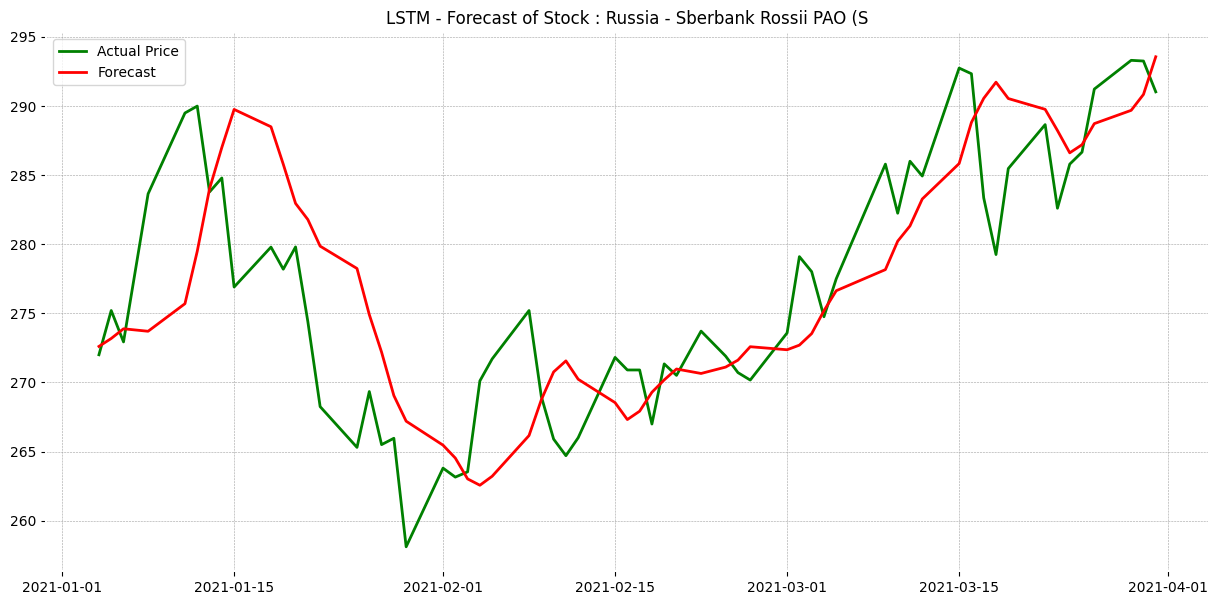

In [22]:
lstm_model_rus, forecast_lstm_rus = lstm(df_rus,name=company_name[0])

Observation:

After trying different time series forecasting models for our initial dataset focused on Russia's Sberbank Stocks, LSTM model is the best fit.

  1. **Exponential Smoothing**: While Exponential Smoothing is straightforward to implement and captures general trends, its forecasting performance diminishes with intricate trends, complex patterns, or long-term dependencies.

  2. **FB Prophet**: Designed to handle missing data and outliers effectively, FB Prophet can also accommodate seasonality and holidays. However, it's not most suitable choice for rapidly changing trends and complex patterns.

  3.**ARIMA (AutoRegressive Integrated Moving Average)**: ARIMA performs well with linear trends and stationary time series, and it can capture seasonality through differencing. But, its efficacy diminishes when faced with non-linear patterns, making it less suitable for forecasting complex trends.

  4. **LSTM (Long Short-Term Memory)**: LSTM stands out for its ability to capture complex, non-linear relationships and it can learn well from long sequences of data and capture temporal dependencies.

Why LSTM Might Be Preferred:
*   **Non-Linearity**: Stock prices often exhibit non-linear patterns, and LSTMs are well-suited for capturing such complex relationships.
*   **Temporal Dependencies**: LSTMs can capture long-term dependencies in time series data, which is crucial for stock price forecasting.
*  **Adaptability**: LSTMs are capable of adapting to changing patterns over time, making them suitable for dynamic stock markets


2021-01-26 00:00:00: Buy 371.28 stocks @ 269.34
2021-01-27 00:00:00: Hold stocks
2021-01-28 00:00:00: Hold stocks
2021-01-29 00:00:00: Hold stocks
2021-02-01 00:00:00: Hold stocks
2021-02-02 00:00:00: Hold stocks
2021-02-03 00:00:00: Hold stocks
2021-02-04 00:00:00: Hold stocks
2021-02-05 00:00:00: Hold stocks
2021-02-08 00:00:00: Hold stocks
2021-02-09 00:00:00: Hold stocks
2021-02-10 00:00:00: Hold stocks
2021-02-11 00:00:00: Hold stocks
2021-02-12 00:00:00: Hold stocks
2021-02-15 00:00:00: Hold stocks
2021-02-16 00:00:00: Hold stocks
2021-02-17 00:00:00: Hold stocks
2021-02-18 00:00:00: Hold stocks
2021-02-19 00:00:00: Hold stocks
2021-02-20 00:00:00: Hold stocks
2021-02-22 00:00:00: Hold stocks
2021-02-24 00:00:00: Hold stocks
2021-02-25 00:00:00: Hold stocks
2021-02-26 00:00:00: Hold stocks
2021-03-01 00:00:00: Hold stocks
2021-03-02 00:00:00: Hold stocks
2021-03-03 00:00:00: Hold stocks
2021-03-04 00:00:00: Hold stocks
2021-03-05 00:00:00: Hold stocks
2021-03-09 00:00:00: Hold st

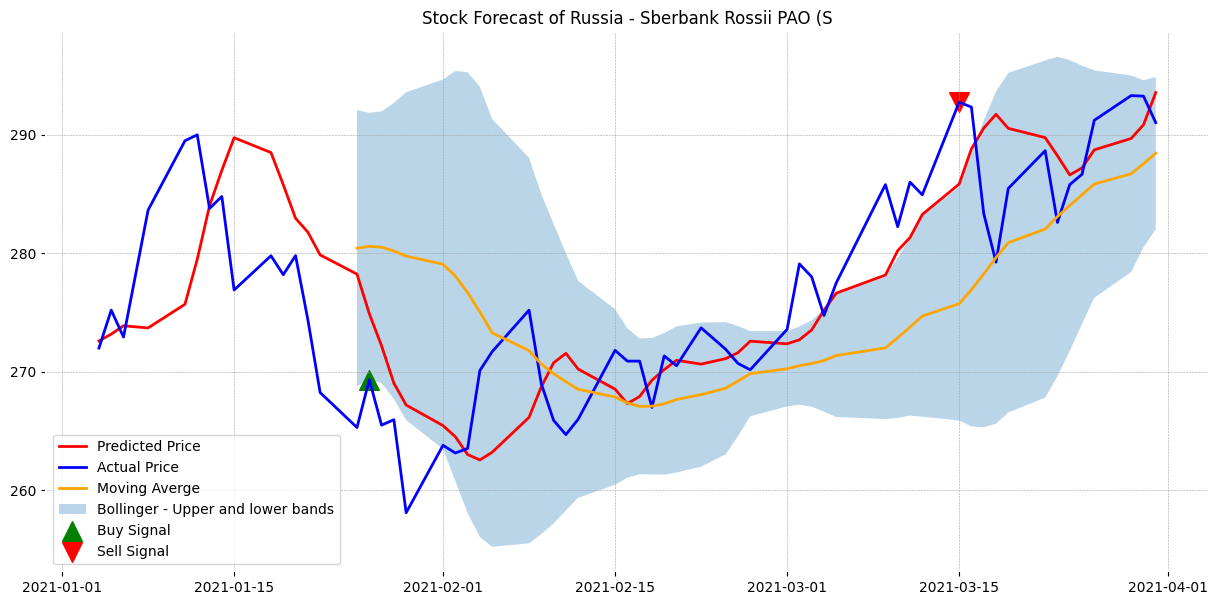

In [250]:
trading_algo(rolling_window=15,forecast=forecast_lstm_rus,stoploss=.1,initial_capital = 100000,LB_threshold = 0.001,max_hold=5,min_margin=0.08,name=company_name[0])

For Russia's Sberbank stocks, we have achieved a 8.7% Capital Return.

Estimated Returns:108687.90, Estimated Gain/Loss:8687.90

# **Turkey** - Koc Holding (KCHOL)

In [149]:
df_dic[company_name[1]].info()
print(df_dic[company_name[1]].tail())

<class 'pandas.core.frame.DataFrame'>
Index: 316 entries, 2021-03-31 00:00:00 to Highest: 25.48
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     316 non-null    object 
 1   Open      316 non-null    object 
 2   High      316 non-null    object 
 3   Low       316 non-null    object 
 4   Vol.      315 non-null    object 
 5   Change %  315 non-null    float64
dtypes: float64(1), object(5)
memory usage: 17.3+ KB
                             Price               Open            High  \
Date                                                                    
2020-01-07 00:00:00          19.93              20.22           20.28   
2020-01-06 00:00:00          20.08              20.34           20.34   
2020-01-03 00:00:00           20.3               20.3           20.44   
2020-01-02 00:00:00          20.38              20.42           20.44   
Highest: 25.48       Lowest: 12.38  Difference: 13.10  Average: 17.86

In [27]:
df_tur= ini_preprocess(df_dic[company_name[1]])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315 entries, 2020-01-02 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     315 non-null    float64
 1   Open      315 non-null    float64
 2   High      315 non-null    float64
 3   Low       315 non-null    float64
 4   Vol.      315 non-null    float64
 5   Change %  315 non-null    float64
dtypes: float64(6)
memory usage: 17.2 KB
            Price   Open   High    Low        Vol.  Change %
Date                                                        
2021-03-25  20.02  20.50  20.86  20.02  15930000.0   -0.0148
2021-03-26  19.25  20.28  20.36  19.10  21350000.0   -0.0385
2021-03-29  19.10  19.24  19.67  19.10  16560000.0   -0.0078
2021-03-30  19.50  19.12  19.81  19.03  21050000.0    0.0209
2021-03-31  19.41  19.42  19.63  19.27  13140000.0   -0.0046


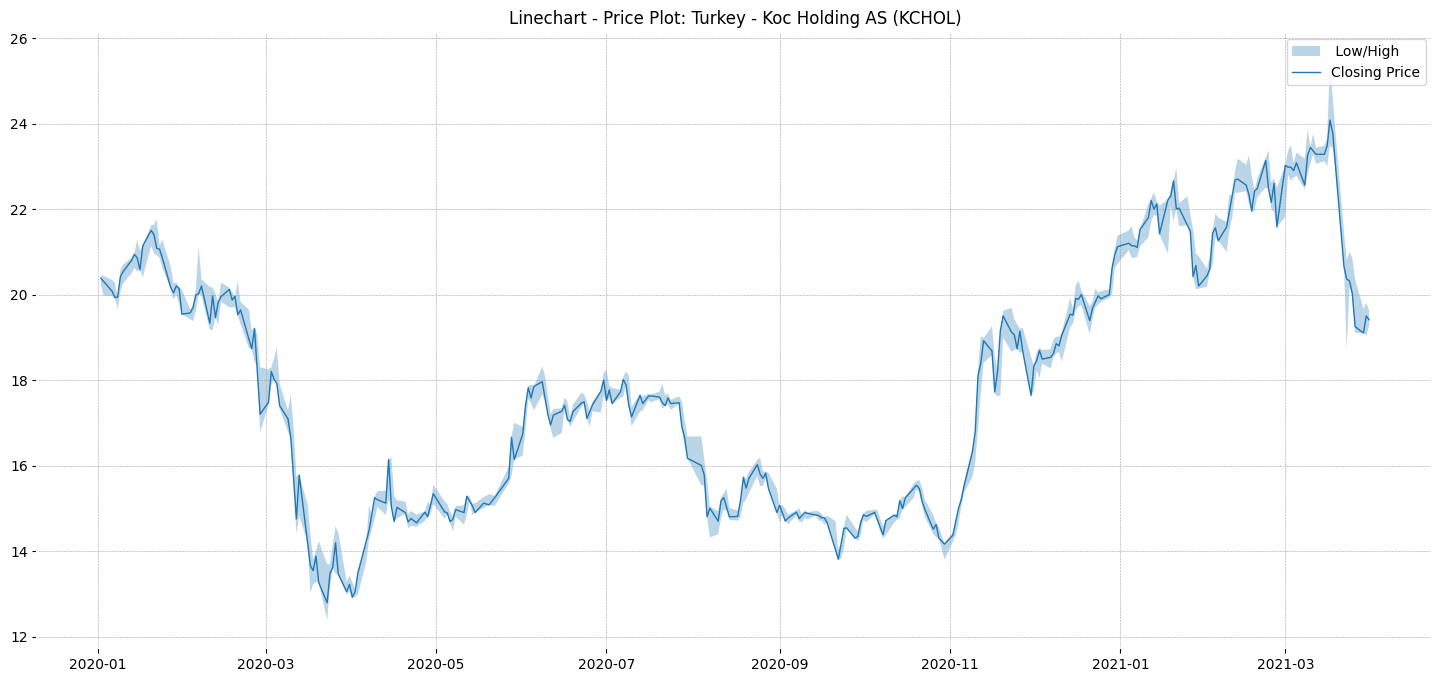

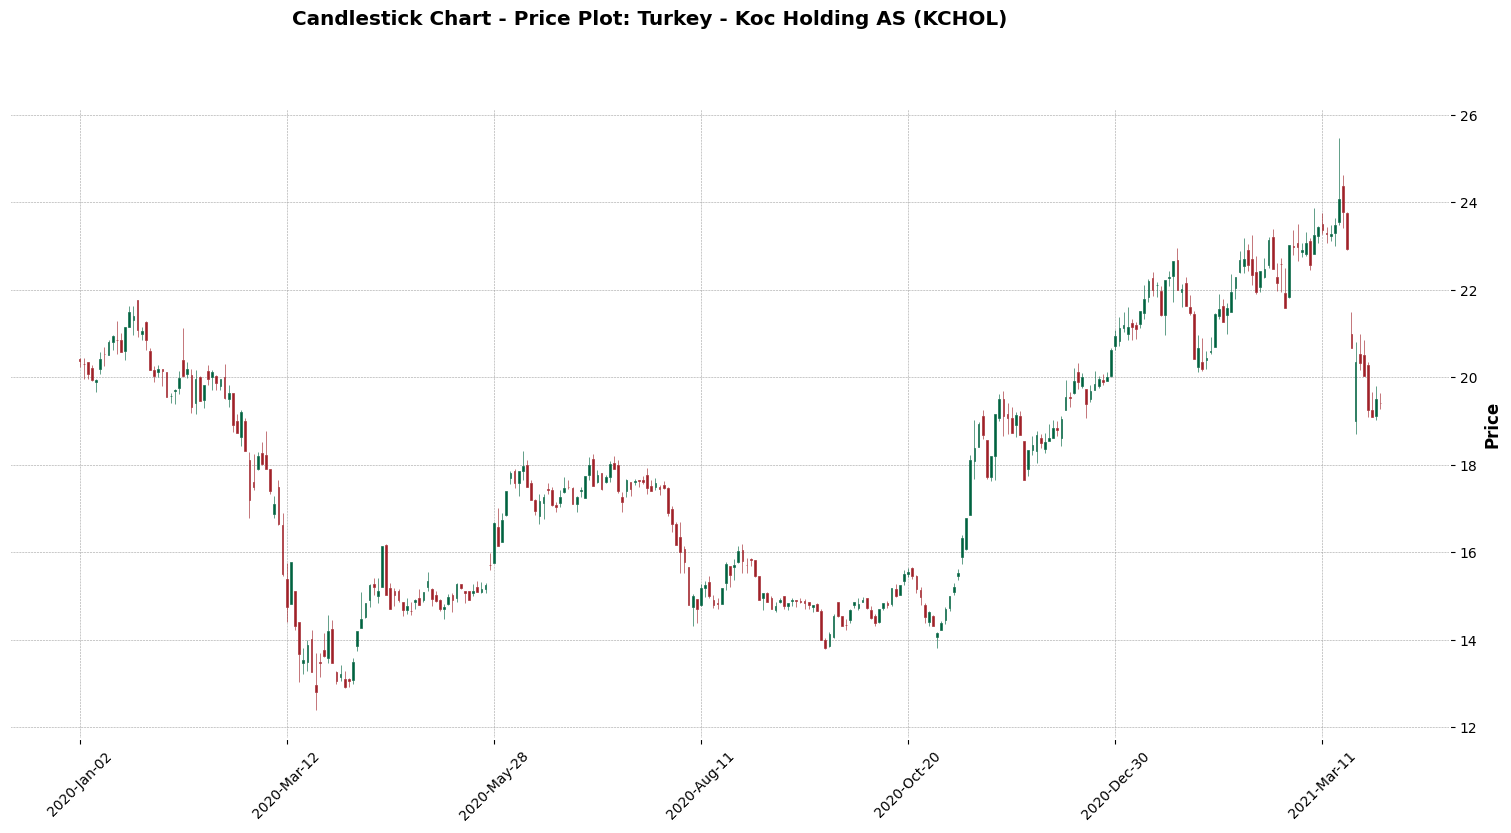

In [28]:
EDA_plot(df_tur,name=company_name[1])

scaled price dataset (315, 1)
scaled tensor (310, 5, 1) (310, 1)
training (197, 5, 1) (197, 1)
validation (50, 5, 1) (50, 1)
test (63, 5, 1) (63, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
7/7 [==============================] - 6s 598ms/step - loss: 0.1191 - root_mean_squared_error: 0.3451 - val_loss: 0.1368 - val_root_mean_squared_error: 0.3699
Epoch 2/50
7/7 [==============================] - 3s 462ms/step - loss: 0.0495 - root_mean_squa

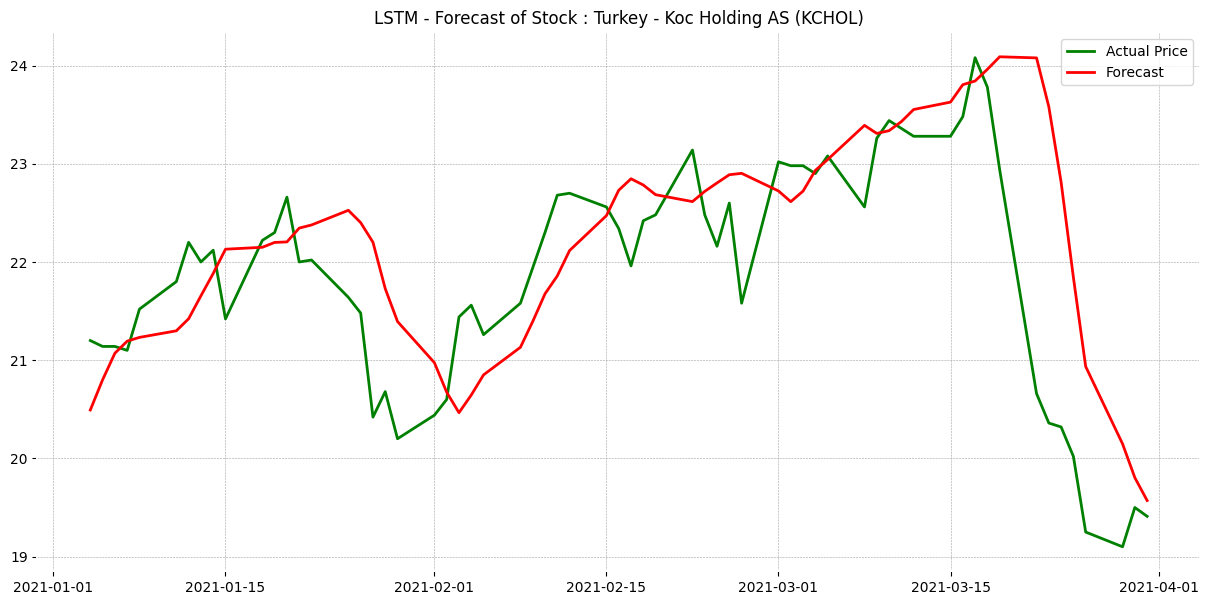

In [29]:
lstm_model_tur, forecast_lstm_tur = lstm(df_tur,name=company_name[1])

2021-01-28 00:00:00: Buy 4835.59 stocks @ 20.68
2021-01-29 00:00:00: Hold stocks
2021-02-01 00:00:00: Hold stocks
2021-02-02 00:00:00: Hold stocks
2021-02-03 00:00:00: Hold stocks
2021-02-04 00:00:00: Hold stocks
2021-02-05 00:00:00: Hold stocks
2021-02-08 00:00:00: Hold stocks
2021-02-09 00:00:00: Hold stocks
2021-02-10 00:00:00: Hold stocks
2021-02-11 00:00:00: Hold stocks
2021-02-12 00:00:00: Hold stocks
2021-02-15 00:00:00: Hold stocks
2021-02-16 00:00:00: Hold stocks
2021-02-17 00:00:00: Hold stocks
2021-02-18 00:00:00: Hold stocks
2021-02-19 00:00:00: Hold stocks
2021-02-22 00:00:00: Sell @ 23.14
Estimated Returns:111895.55, Estimated Gain/Loss:11895.55
2021-03-23 00:00:00: Buy 5495.85 stocks @ 20.36
2021-03-24 00:00:00: Hold stocks
2021-03-25 00:00:00: Hold stocks
2021-03-26 00:00:00: Hold stocks
2021-03-29 00:00:00: Hold stocks
2021-03-30 00:00:00: Hold stocks
2021-03-31 00:00:00: Hold stocks
Return of capital is 11.9%


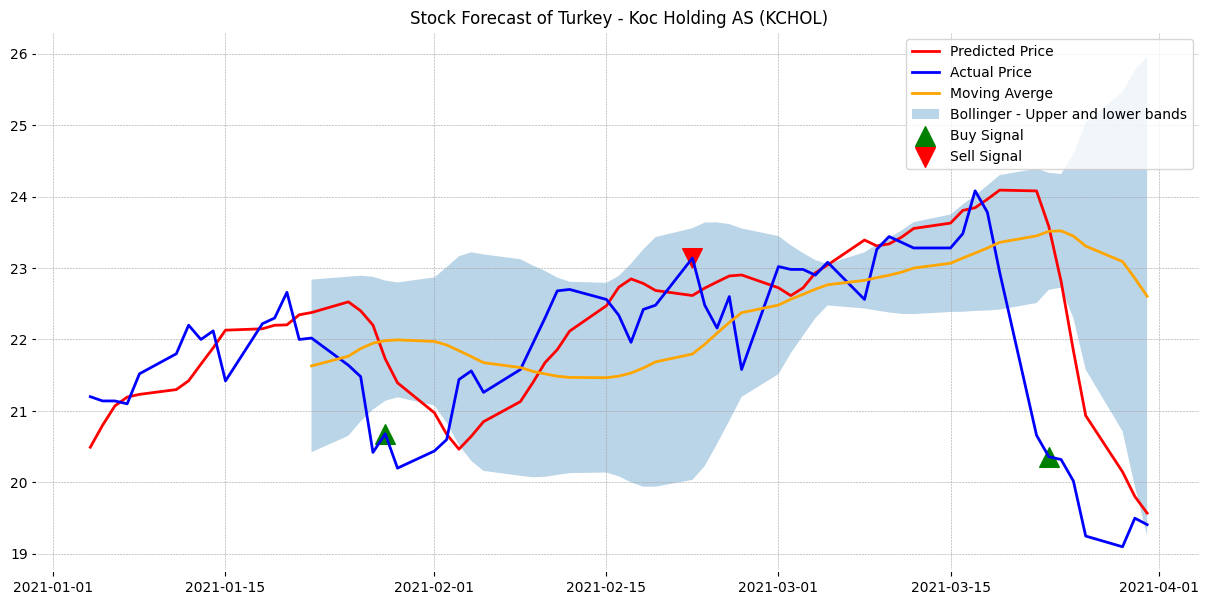

In [235]:
trading_algo(rolling_window=15,forecast=forecast_lstm_tur,stoploss=.1,initial_capital = 100000,LB_threshold = 0.05,max_hold=5,min_margin=.1,name =company_name[1])

For Turkey's - Koc Holding stocks, we have achieved a 11.9% Capital Returns without any losses.

Estimated Returns:111895.55, Estimated Gain/Loss:11895.55

# **Egypt** - Medinet Nasr Housing

In [31]:
df_dic[company_name[2]].info()
print(df_dic[company_name[2]].tail())

<class 'pandas.core.frame.DataFrame'>
Index: 306 entries, 2021-03-31 00:00:00 to Highest: 4.92
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     306 non-null    object 
 1   Open      306 non-null    object 
 2   High      306 non-null    object 
 3   Low       306 non-null    object 
 4   Vol.      305 non-null    object 
 5   Change %  305 non-null    float64
dtypes: float64(1), object(5)
memory usage: 16.7+ KB
                            Price              Open           High  \
Date                                                                 
2020-01-08 00:00:00          4.41              4.19           4.59   
2020-01-06 00:00:00          4.28              4.16           4.44   
2020-01-05 00:00:00          4.41               4.7            4.7   
2020-01-02 00:00:00          4.81              4.81           4.87   
Highest: 4.92        Lowest: 2.40  Difference: 2.52  Average: 3.55   

                 

In [32]:
df_egypt = ini_preprocess(df_dic[company_name[2]])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 305 entries, 2020-01-02 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     305 non-null    float64
 1   Open      305 non-null    float64
 2   High      305 non-null    float64
 3   Low       305 non-null    float64
 4   Vol.      305 non-null    float64
 5   Change %  305 non-null    float64
dtypes: float64(6)
memory usage: 16.7 KB
            Price  Open  High   Low       Vol.  Change %
Date                                                    
2021-03-25   3.71  3.62  3.78  3.59  2500000.0    0.0137
2021-03-28   3.71  3.76  3.76  3.68  2340000.0    0.0000
2021-03-29   3.70  3.69  3.73  3.68  1250000.0   -0.0027
2021-03-30   3.73  3.71  3.76  3.67  3430000.0    0.0081
2021-03-31   3.75  3.74  3.82  3.71  1570000.0    0.0054


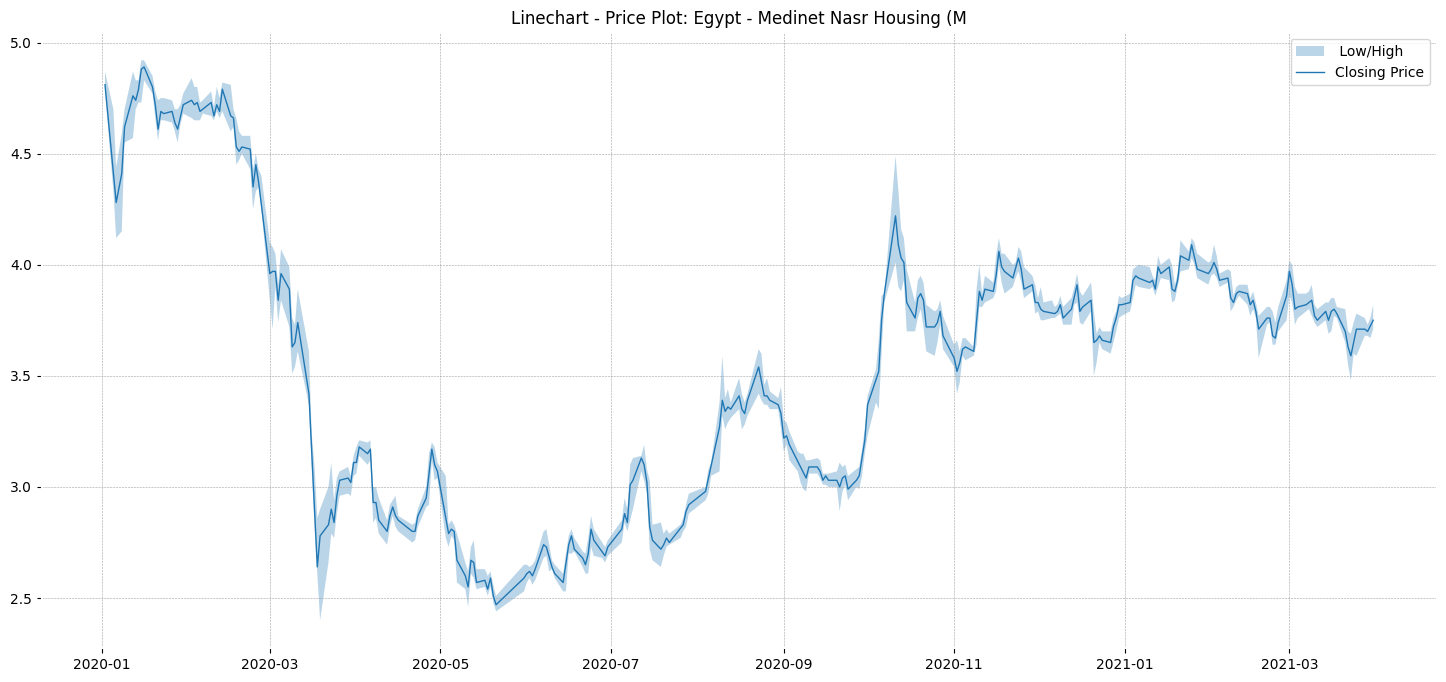

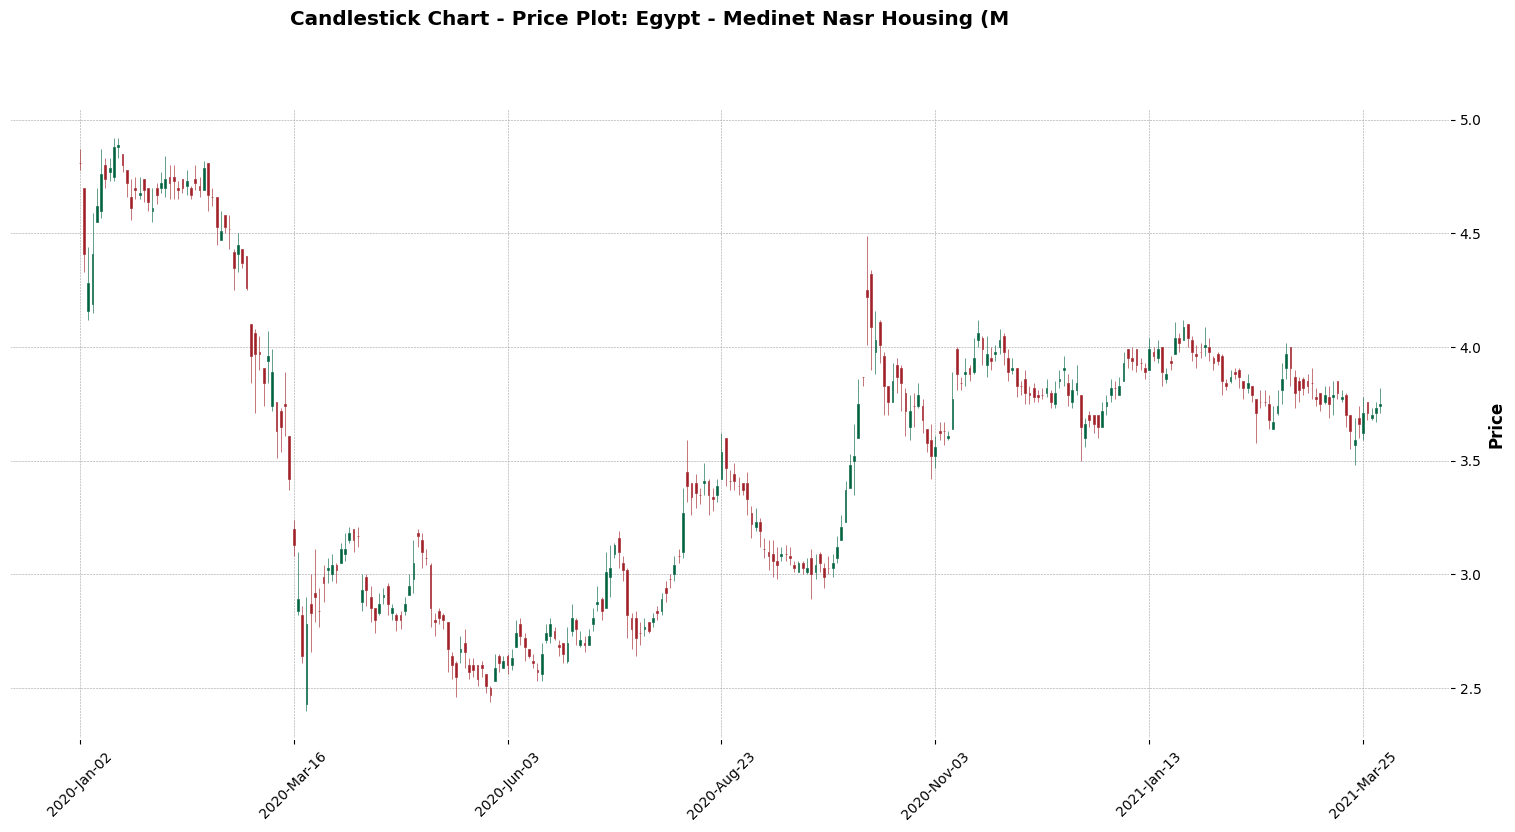

In [33]:
EDA_plot(df_egypt,name=company_name[2])

scaled price dataset (305, 1)
scaled tensor (300, 5, 1) (300, 1)
training (190, 5, 1) (190, 1)
validation (48, 5, 1) (48, 1)
test (62, 5, 1) (62, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
6/6 [==============================] - 6s 628ms/step - loss: 0.1890 - root_mean_squared_error: 0.4347 - val_loss: 0.1691 - val_root_mean_squared_error: 0.4112
Epoch 2/50
6/6 [==============================] - 3s 663ms/step - loss: 0.0936 - root_mean_squa

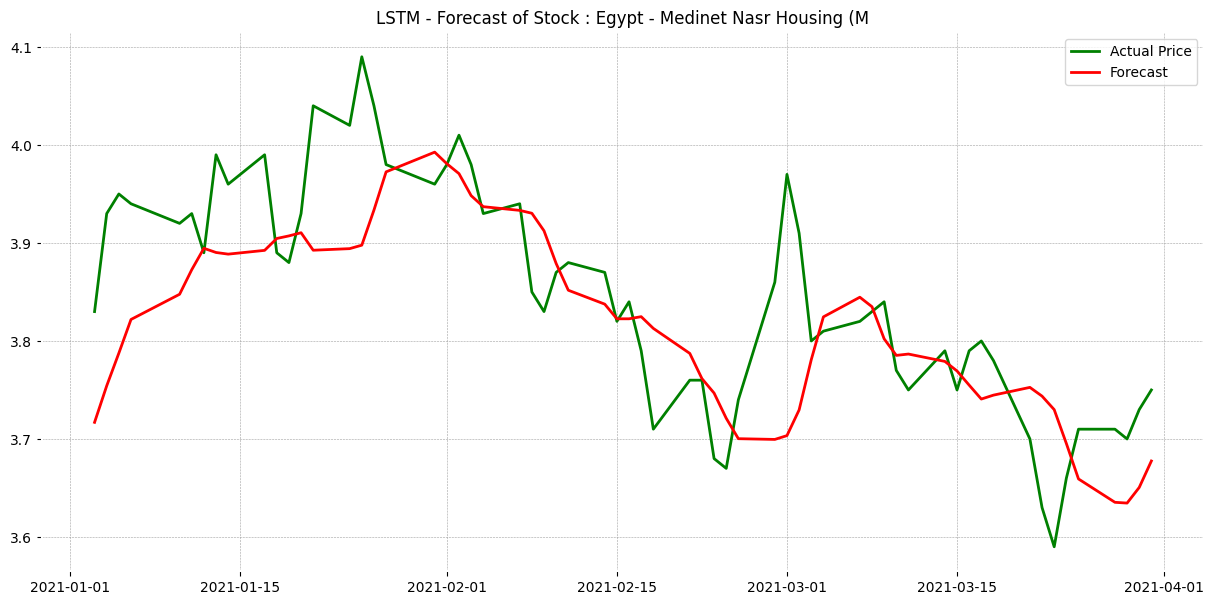

In [34]:
lstm_model_egypt, forecast_lstm_egypt = lstm(df_egypt,name=company_name[2])

2021-02-09 00:00:00: Buy 26109.66 stocks @ 3.83
2021-02-10 00:00:00: Hold stocks
2021-02-11 00:00:00: Hold stocks
2021-02-14 00:00:00: Hold stocks
2021-02-15 00:00:00: Hold stocks
2021-02-16 00:00:00: Hold stocks
2021-02-17 00:00:00: Hold stocks
2021-02-18 00:00:00: Hold stocks
2021-02-21 00:00:00: Hold stocks
2021-02-22 00:00:00: Hold stocks
2021-02-23 00:00:00: Hold stocks
2021-02-24 00:00:00: Hold stocks
2021-02-25 00:00:00: Hold stocks
2021-02-28 00:00:00: Hold stocks
2021-03-01 00:00:00: Sell @ 3.97
Estimated Returns:103655.35, Estimated Gain/Loss:3655.35
2021-03-23 00:00:00: Buy 28873.36 stocks @ 3.59
2021-03-24 00:00:00: Sell @ 3.66
Estimated Returns:105676.49, Estimated Gain/Loss:5676.49
Return of capital is 5.7%


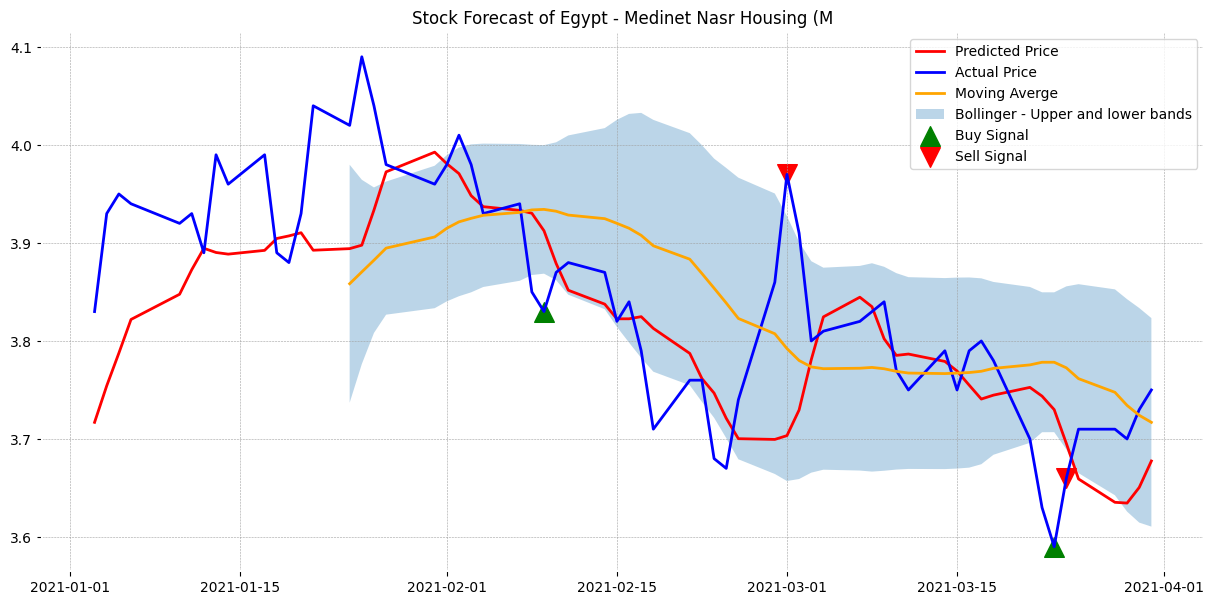

In [229]:
trading_algo(rolling_window=15,forecast=forecast_lstm_egypt,stoploss=.1,initial_capital = 100000,LB_threshold = 0.001,max_hold=5,min_margin=0.01,name=company_name[2])

For Egypt's - Medinet Nasr Housing stocks, we have achieved a 5.7% Capital return without any loss.


Estimated Returns:105676.49, Estimated Gain/Loss:5676.49

# **Brazil** - Minerva SABrazil

In [85]:
df_dic[company_name[3]].info()
print(df_dic[company_name[3]].tail())
name = company_name[3]

<class 'pandas.core.frame.DataFrame'>
Index: 310 entries, 2021-03-31 00:00:00 to Highest: 15.30
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     310 non-null    object 
 1   Open      310 non-null    object 
 2   High      310 non-null    object 
 3   Low       310 non-null    object 
 4   Vol.      309 non-null    object 
 5   Change %  309 non-null    float64
dtypes: float64(1), object(5)
memory usage: 17.0+ KB
                            Price              Open            High  \
Date                                                                  
2020-01-07 00:00:00         13.48             13.03           13.48   
2020-01-06 00:00:00         12.89              12.9           12.91   
2020-01-03 00:00:00          12.9             12.45           12.93   
2020-01-02 00:00:00         12.57             12.88           12.99   
Highest: 15.30       Lowest: 5.81  Difference: 9.49  Average: 11.38   

         

In [86]:
df_br= ini_preprocess(df_dic[company_name[3]])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 309 entries, 2020-01-02 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     309 non-null    float64
 1   Open      309 non-null    float64
 2   High      309 non-null    float64
 3   Low       309 non-null    float64
 4   Vol.      309 non-null    float64
 5   Change %  309 non-null    float64
dtypes: float64(6)
memory usage: 16.9 KB
            Price   Open   High    Low        Vol.  Change %
Date                                                        
2021-03-25   9.80  10.01  10.01   9.66   8880000.0   -0.0151
2021-03-26   9.83   9.80   9.94   9.70   5110000.0    0.0031
2021-03-29  10.47   9.85  10.50   9.81  22040000.0    0.0651
2021-03-30  10.36  10.41  10.62  10.30   9930000.0   -0.0105
2021-03-31  10.20  10.35  10.40  10.12   7770000.0   -0.0154


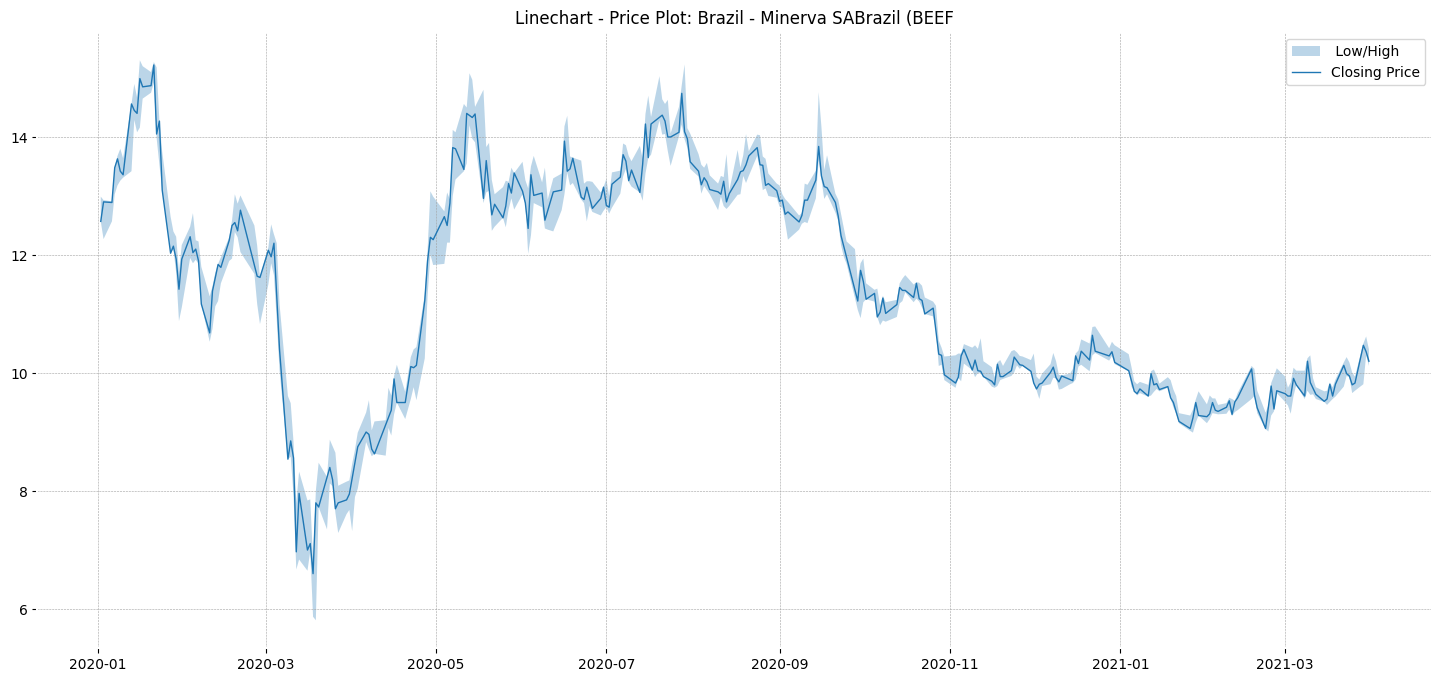

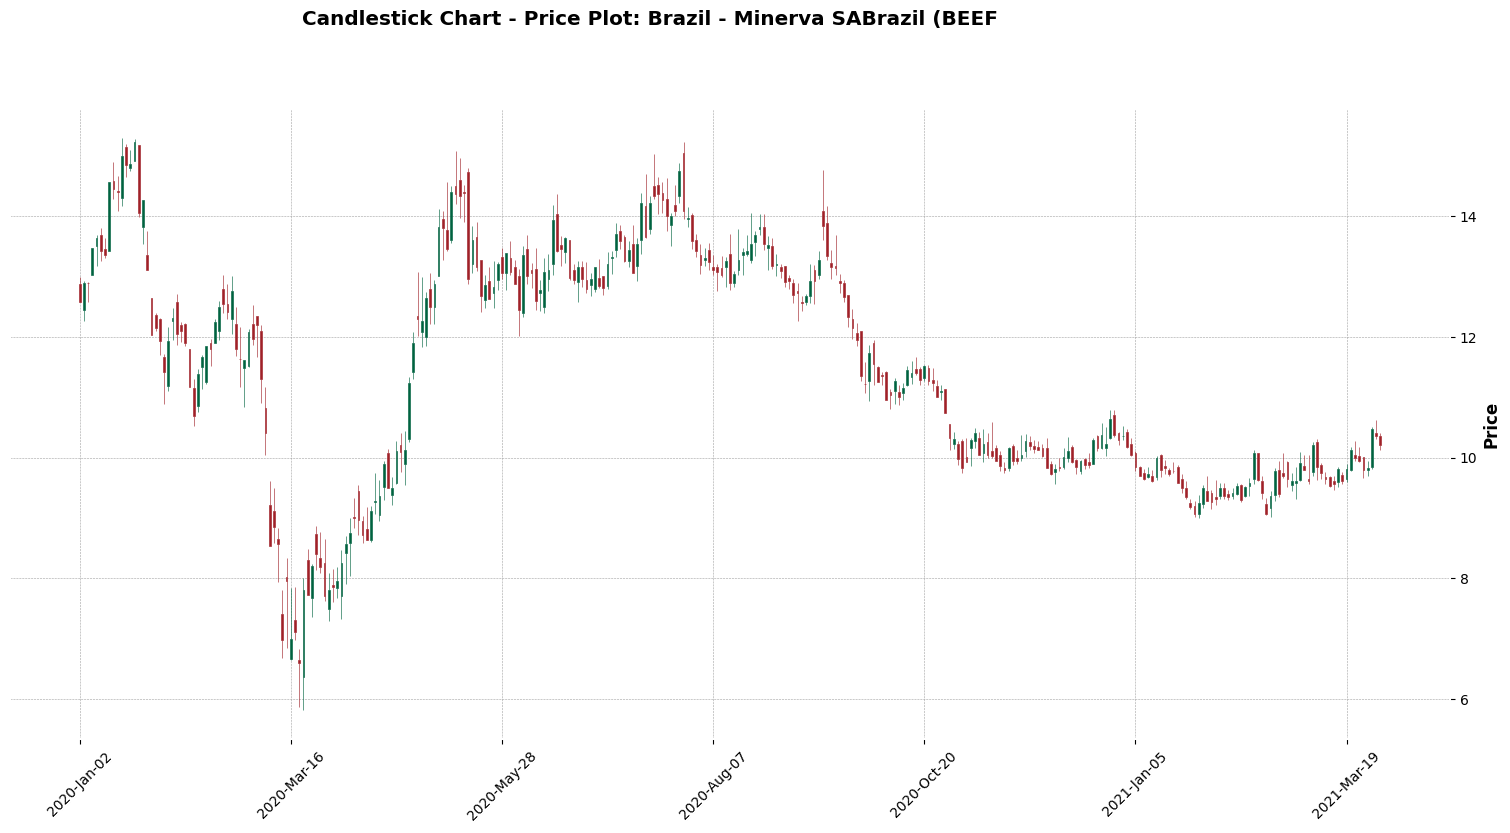

In [87]:
EDA_plot(df_br,name=company_name[3])

scaled price dataset (309, 1)
scaled tensor (304, 5, 1) (304, 1)
training (195, 5, 1) (195, 1)
validation (49, 5, 1) (49, 1)
test (60, 5, 1) (60, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
7/7 [==============================] - 6s 623ms/step - loss: 0.5251 - root_mean_squared_error: 0.7246 - val_loss: 0.1186 - val_root_mean_squared_error: 0.3444
Epoch 2/50
7/7 [==============================] - 3s 565ms/step - loss: 0.2732 - root_mean_squa

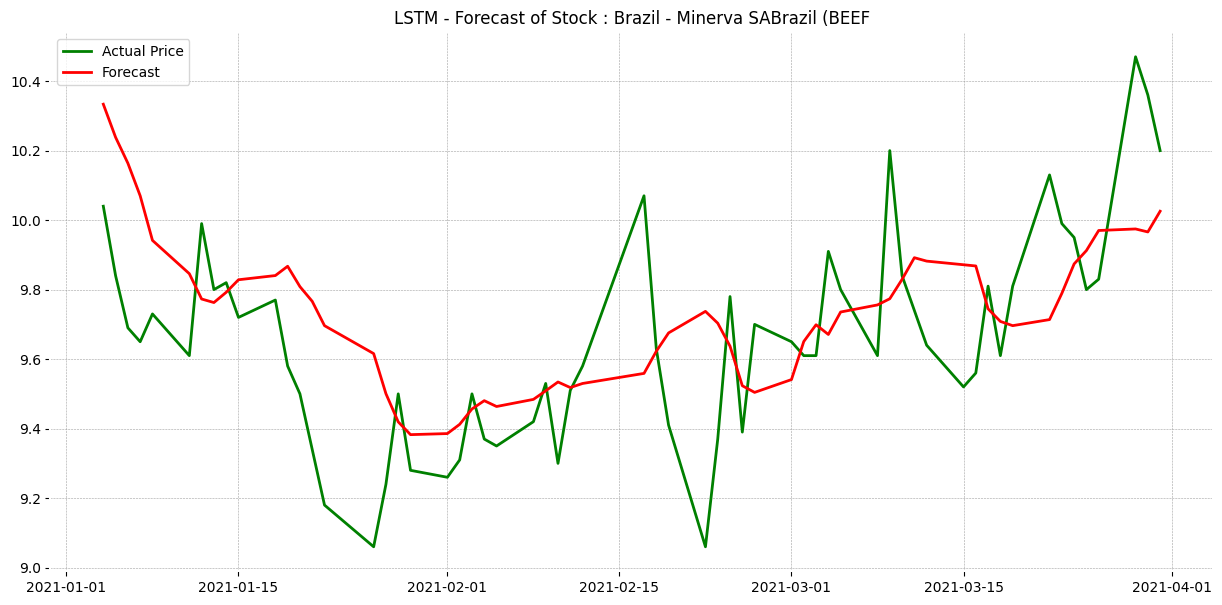

In [88]:
lstm_model_br, forecast_lstm_br = lstm(df_br,name=company_name[3])

2021-01-26 00:00:00: Buy 11037.53 stocks @ 9.06
2021-01-27 00:00:00: Hold stocks
2021-01-28 00:00:00: Hold stocks
2021-01-29 00:00:00: Hold stocks
2021-02-01 00:00:00: Hold stocks
2021-02-02 00:00:00: Hold stocks
2021-02-03 00:00:00: Hold stocks
2021-02-04 00:00:00: Hold stocks
2021-02-05 00:00:00: Hold stocks
2021-02-08 00:00:00: Hold stocks
2021-02-09 00:00:00: Hold stocks
2021-02-10 00:00:00: Hold stocks
2021-02-11 00:00:00: Hold stocks
2021-02-12 00:00:00: Hold stocks
2021-02-17 00:00:00: Sell @ 10.07
Estimated Returns:111147.90, Estimated Gain/Loss:11147.90
Return of capital is 11.1%


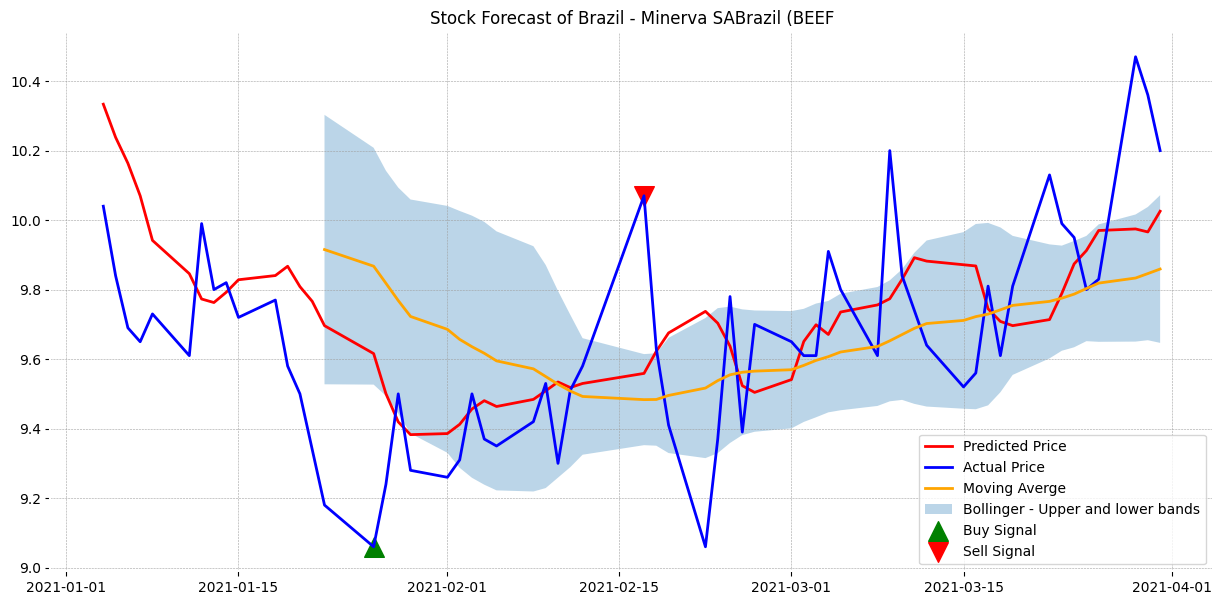

In [248]:
trading_algo(rolling_window=15,forecast=forecast_lstm_br,stoploss=.1,initial_capital=100000,LB_threshold = 0.001,max_hold=5,min_margin=0.1,name=company_name[3])

For Brazil's - Minerva SABrazil stocks, we have achieved a 11.1% Capital Return, without any losses.


Estimated Returns:111147.90, Estimated Gain/Loss:11147.90

# **Argentina** - Pampa Energia SA

In [19]:
df_dic[company_name[4]].info()
print(df_dic[company_name[4]].tail())

<class 'pandas.core.frame.DataFrame'>
Index: 301 entries, 2021-03-31 00:00:00 to Highest: 90.000
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     301 non-null    object 
 1   Open      301 non-null    object 
 2   High      301 non-null    object 
 3   Low       301 non-null    object 
 4   Vol.      300 non-null    object 
 5   Change %  300 non-null    float64
dtypes: float64(1), object(5)
memory usage: 16.5+ KB
                              Price                Open             High  \
Date                                                                       
2020-01-07 00:00:00            47.6               48.35               49   
2020-01-06 00:00:00            48.5                48.4             48.7   
2020-01-03 00:00:00            48.8               48.25            49.45   
2020-01-02 00:00:00           48.25               49.35             50.2   
Highest: 90.000      Lowest: 32.000  Difference: 5

In [20]:
df_ar= ini_preprocess(df_dic[company_name[4]])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2020-01-02 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     300 non-null    float64
 1   Open      300 non-null    float64
 2   High      300 non-null    float64
 3   Low       300 non-null    float64
 4   Vol.      300 non-null    float64
 5   Change %  300 non-null    float64
dtypes: float64(6)
memory usage: 16.4 KB
            Price   Open   High    Low      Vol.  Change %
Date                                                      
2021-03-25  83.60  85.20  87.30  82.10  389780.0   -0.0313
2021-03-26  81.85  84.00  84.60  80.70  462550.0   -0.0209
2021-03-29  85.00  80.00  86.00  79.00  371220.0    0.0385
2021-03-30  86.10  85.15  86.75  84.60  141400.0    0.0129
2021-03-31  85.15  86.50  88.10  85.15  564300.0   -0.0110


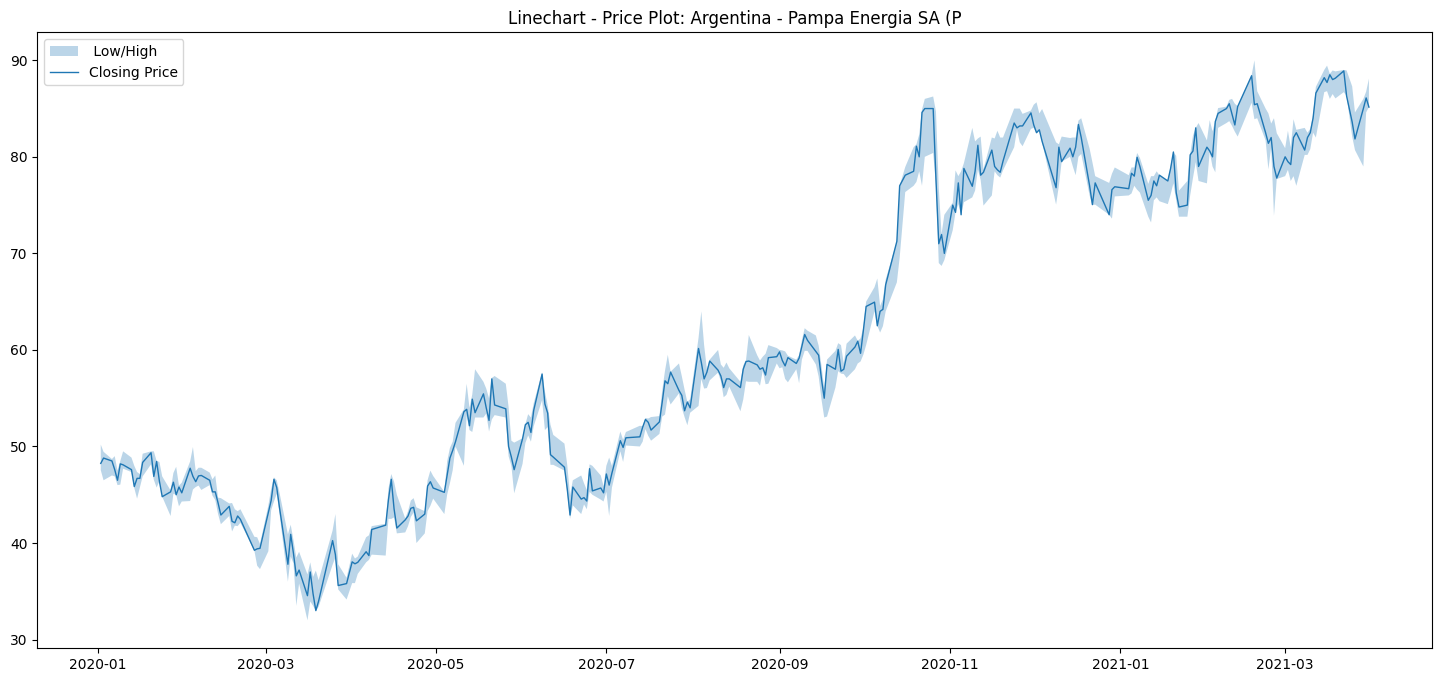

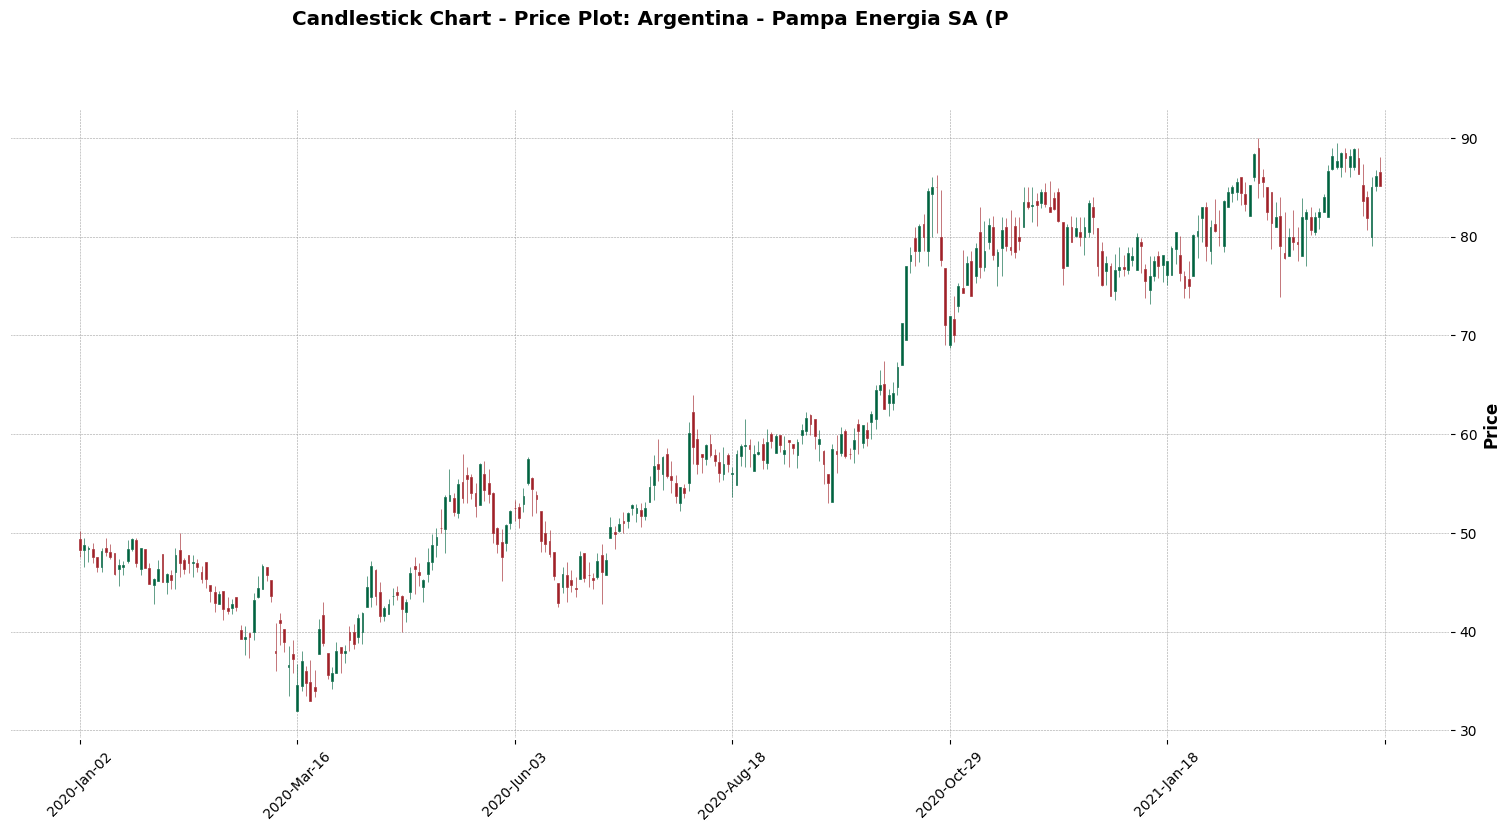

In [21]:
EDA_plot(df_ar,name=company_name[4])

scaled price dataset (300, 1)
scaled tensor (295, 5, 1) (295, 1)
training (188, 5, 1) (188, 1)
validation (47, 5, 1) (47, 1)
test (60, 5, 1) (60, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
6/6 [==============================] - 9s 1s/step - loss: 0.0773 - root_mean_squared_error: 0.2781 - val_loss: 0.3146 - val_root_mean_squared_error: 0.5609
Epoch 2/50
6/6 [==============================] - 3s 560ms/step - loss: 0.0311 - root_mean_squared

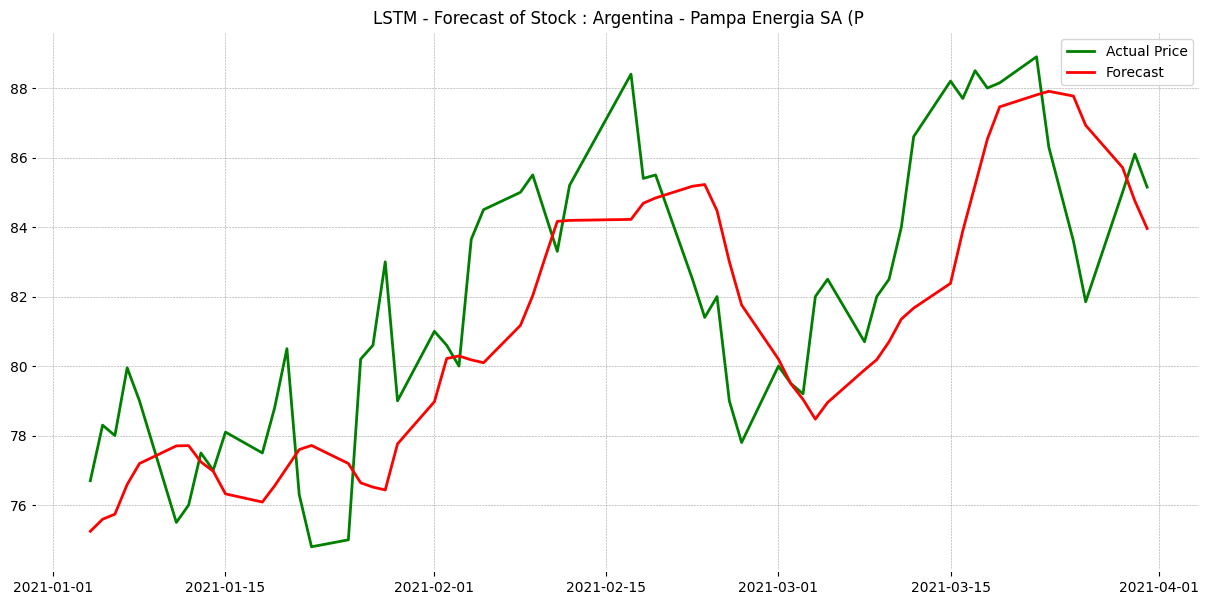

In [23]:
lstm_model_ar, forecast_lstm_ar = lstm(df_ar,name=company_name[4])

2021-01-25 00:00:00: Buy 1333.33 stocks @ 75.00
2021-01-26 00:00:00: Hold stocks
2021-01-27 00:00:00: Hold stocks
2021-01-28 00:00:00: Sell @ 83.0
Estimated Returns:110666.67, Estimated Gain/Loss:10666.67
2021-02-25 00:00:00: Buy 1400.84 stocks @ 79.00
2021-02-26 00:00:00: Hold stocks
2021-03-01 00:00:00: Hold stocks
2021-03-02 00:00:00: Hold stocks
2021-03-03 00:00:00: Hold stocks
2021-03-04 00:00:00: Hold stocks
2021-03-05 00:00:00: Hold stocks
2021-03-08 00:00:00: Hold stocks
2021-03-09 00:00:00: Hold stocks
2021-03-10 00:00:00: Hold stocks
2021-03-11 00:00:00: Hold stocks
2021-03-12 00:00:00: Sell @ 86.6
Estimated Returns:121313.08, Estimated Gain/Loss:21313.08
Return of capital is 21.3%


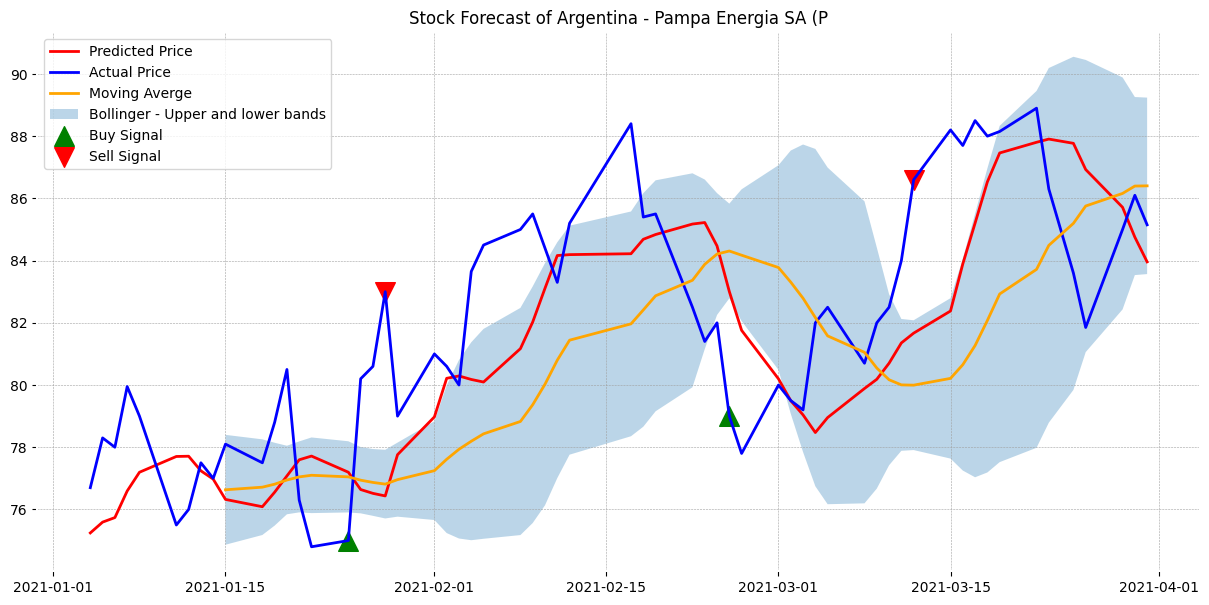

In [24]:
trading_algo(rolling_window=10,forecast=forecast_lstm_ar,stoploss=.1,initial_capital = 100000,LB_threshold = 0.001,max_hold=5,min_margin=0.08,name=company_name[4])

For Argentina's - Pampa Energia SA Stocks, We have achieved a 21.2% Capital Return, without any losses.

Estimated Returns:121313.08, Estimated Gain/Loss:21313.08

# **Colombia** - Cementos Argos SA

In [95]:
df_dic[company_name[5]].info()
print(df_dic[company_name[5]].tail())

<class 'pandas.core.frame.DataFrame'>
Index: 304 entries, 2021-03-31 00:00:00 to Highest: 7,300.0
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     304 non-null    object 
 1   Open      304 non-null    object 
 2   High      304 non-null    object 
 3   Low       304 non-null    object 
 4   Vol.      303 non-null    object 
 5   Change %  303 non-null    float64
dtypes: float64(1), object(5)
memory usage: 16.6+ KB
                               Price                 Open              High  \
Date                                                                          
2020-01-08 00:00:00             6880                 6940              6950   
2020-01-07 00:00:00             6950                 6950              6950   
2020-01-03 00:00:00             7000                 7040              7100   
2020-01-02 00:00:00             7120                 7300              7300   
Highest: 7,300.0     Lowest: 2,

In [96]:
df_col= ini_preprocess(df_dic[company_name[5]])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 303 entries, 2020-01-02 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     303 non-null    float64
 1   Open      303 non-null    float64
 2   High      303 non-null    float64
 3   Low       303 non-null    float64
 4   Vol.      303 non-null    float64
 5   Change %  303 non-null    float64
dtypes: float64(6)
memory usage: 16.6 KB
             Price    Open    High     Low      Vol.  Change %
Date                                                          
2021-03-25  5030.0  5035.0  5045.0  4950.0  317060.0    0.0010
2021-03-26  5020.0  5085.0  5085.0  4980.0  203460.0   -0.0020
2021-03-29  5045.0  5020.0  5045.0  5015.0  117540.0    0.0050
2021-03-30  5100.0  5010.0  5100.0  5010.0  583700.0    0.0109
2021-03-31  5150.0  5100.0  5170.0  5100.0  212440.0    0.0098


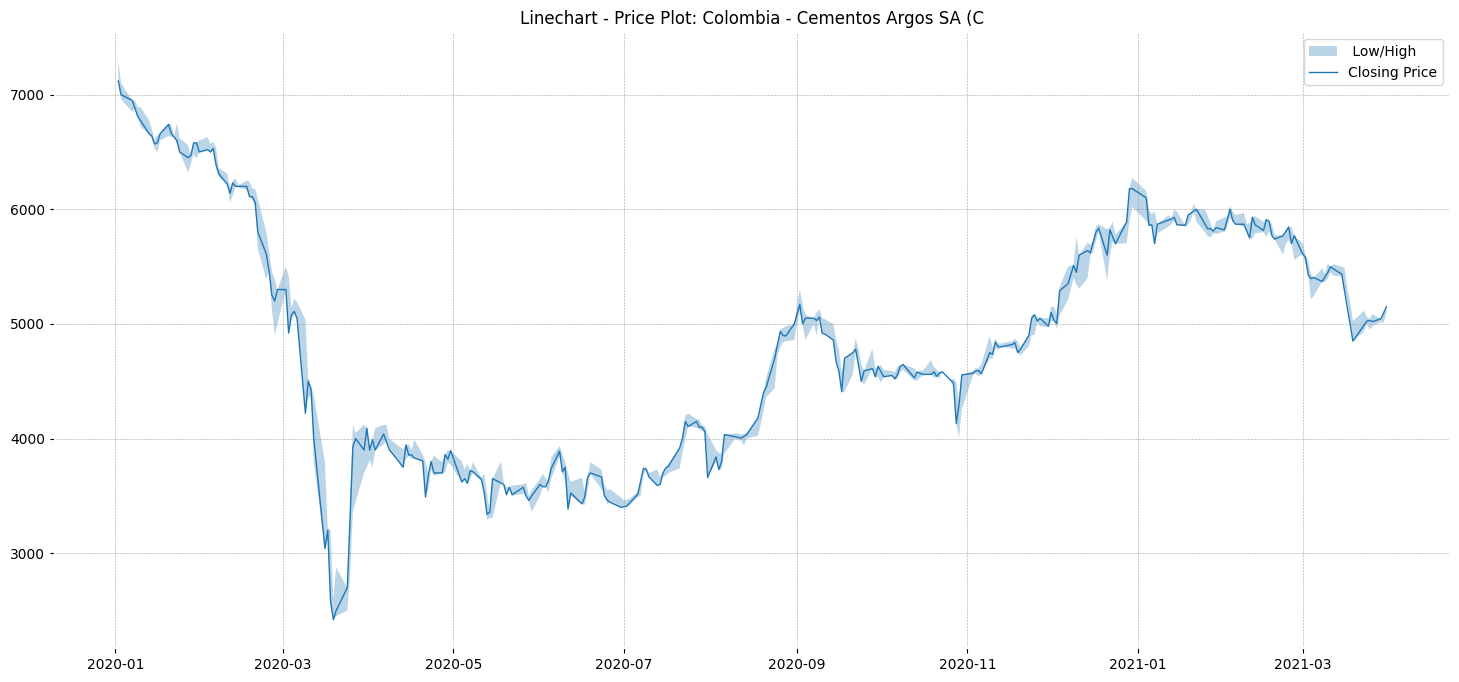

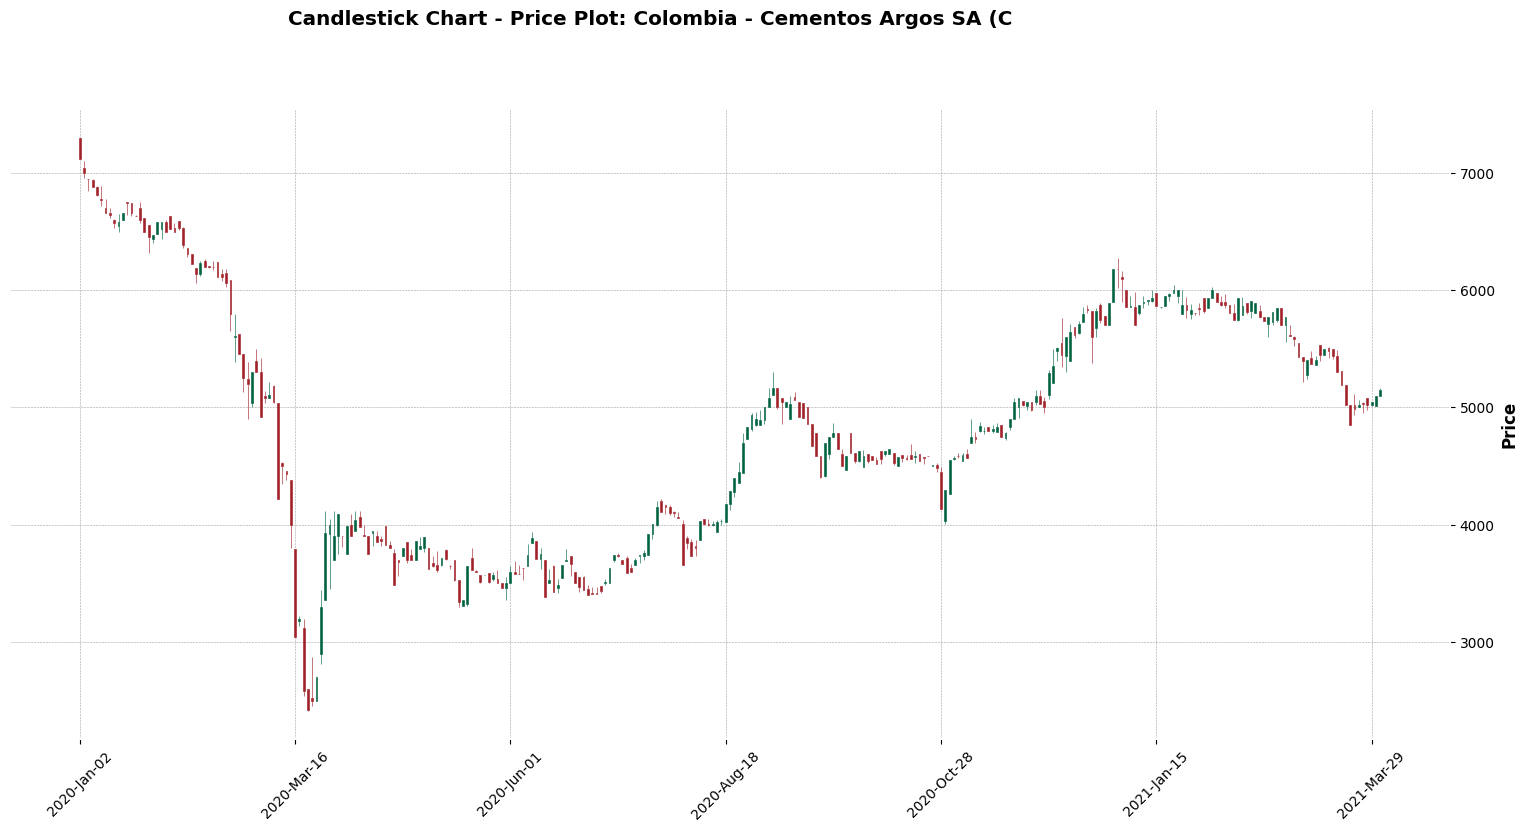

In [97]:
EDA_plot(df_col,name=company_name[5])

scaled price dataset (303, 1)
scaled tensor (298, 5, 1) (298, 1)
training (189, 5, 1) (189, 1)
validation (48, 5, 1) (48, 1)
test (61, 5, 1) (61, 1)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 64)                16896     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
6/6 [==============================] - 6s 732ms/step - loss: 0.1686 - root_mean_squared_error: 0.4106 - val_loss: 0.1696 - val_root_mean_squared_error: 0.4118
Epoch 2/50
6/6 [==============================] - 3s 660ms/step - loss: 0.0840 - root_mean_squa

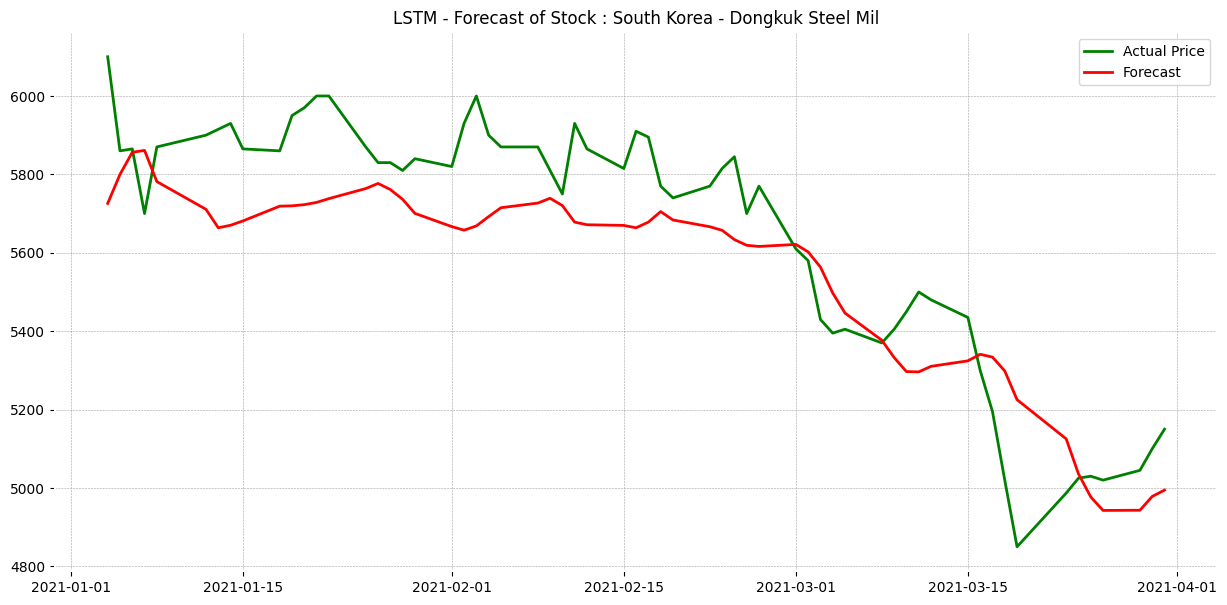

In [139]:
lstm_model_col, forecast_lstm_col = lstm(df_col,name=company_name[5])

2021-03-03 00:00:00: Buy 18.42 stocks @ 5430.00
2021-03-04 00:00:00: Hold stocks
2021-03-05 00:00:00: Hold stocks
2021-03-08 00:00:00: Hold stocks
2021-03-09 00:00:00: Hold stocks
2021-03-10 00:00:00: Hold stocks
2021-03-11 00:00:00: Sell @ 5500.0
Estimated Returns:101289.13, Estimated Gain/Loss:1289.13
2021-03-19 00:00:00: Buy 20.88 stocks @ 4850.00
2021-03-23 00:00:00: Sell @ 4987.0
Estimated Returns:104150.29, Estimated Gain/Loss:4150.29
2021-03-24 00:00:00: Buy 20.73 stocks @ 5025.00
2021-03-25 00:00:00: Hold stocks
2021-03-26 00:00:00: Hold stocks
2021-03-29 00:00:00: Hold stocks
2021-03-30 00:00:00: Sell @ 5100.0
Estimated Returns:105704.77, Estimated Gain/Loss:5704.77
Return of capital is 5.7%


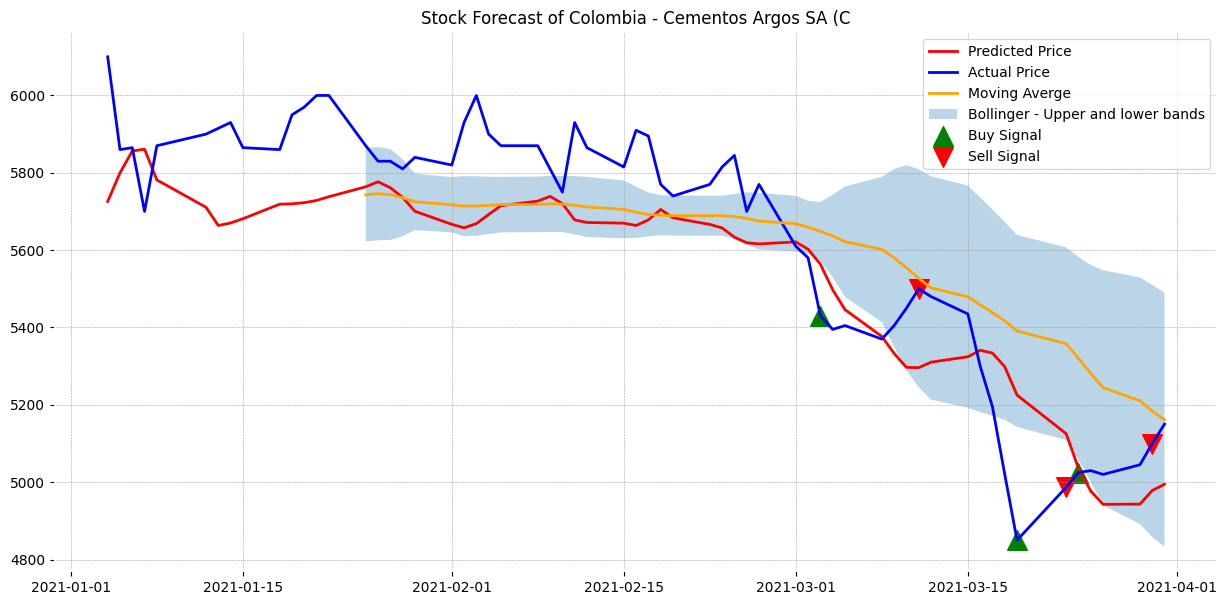

In [243]:
trading_algo(rolling_window=15,forecast=forecast_lstm_col,stoploss=.1,initial_capital=100000,LB_threshold =0.001,max_hold=5,min_margin=0.01,name=company_name[5])

For Colombia's - Cementos Argos SA Stocks, we have achieved a 5.7% Capital Return, without any losses.

Estimated Returns:105704.77, Estimated Gain/Loss:5704.77

# **South Africa** - Impala Platinum

In [100]:
df_dic[company_name[6]].info()
print(df_dic[company_name[6]].tail())

<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 2021-03-31 00:00:00 to Highest: 29,777
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     315 non-null    object 
 1   Open      315 non-null    object 
 2   High      315 non-null    object 
 3   Low       315 non-null    object 
 4   Vol.      314 non-null    object 
 5   Change %  314 non-null    float64
dtypes: float64(1), object(5)
memory usage: 17.2+ KB
                             Price                Open             High  \
Date                                                                      
2020-01-07 00:00:00          14500               14688            14688   
2020-01-06 00:00:00          14620               14985            15045   
2020-01-03 00:00:00          14843               14700            14884   
2020-01-02 00:00:00          14330               14525            14764   
Highest: 29,777      Lowest: 4,476  Difference: 25,301  

In [101]:
df_sa= ini_preprocess(df_dic[company_name[6]])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 314 entries, 2020-01-02 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     314 non-null    float64
 1   Open      314 non-null    float64
 2   High      314 non-null    float64
 3   Low       314 non-null    float64
 4   Vol.      314 non-null    float64
 5   Change %  314 non-null    float64
dtypes: float64(6)
memory usage: 17.2 KB
              Price     Open     High      Low       Vol.  Change %
Date                                                               
2021-03-25  26564.0  25954.0  27128.0  25954.0  2830000.0    0.0255
2021-03-26  27533.0  27083.0  28006.0  26728.0  3360000.0    0.0365
2021-03-29  26980.0  27800.0  28174.0  26614.0  4440000.0   -0.0201
2021-03-30  26898.0  26766.0  27443.0  26360.0  3020000.0   -0.0030
2021-03-31  27373.0  26980.0  27526.0  26657.0  2490000.0    0.0177


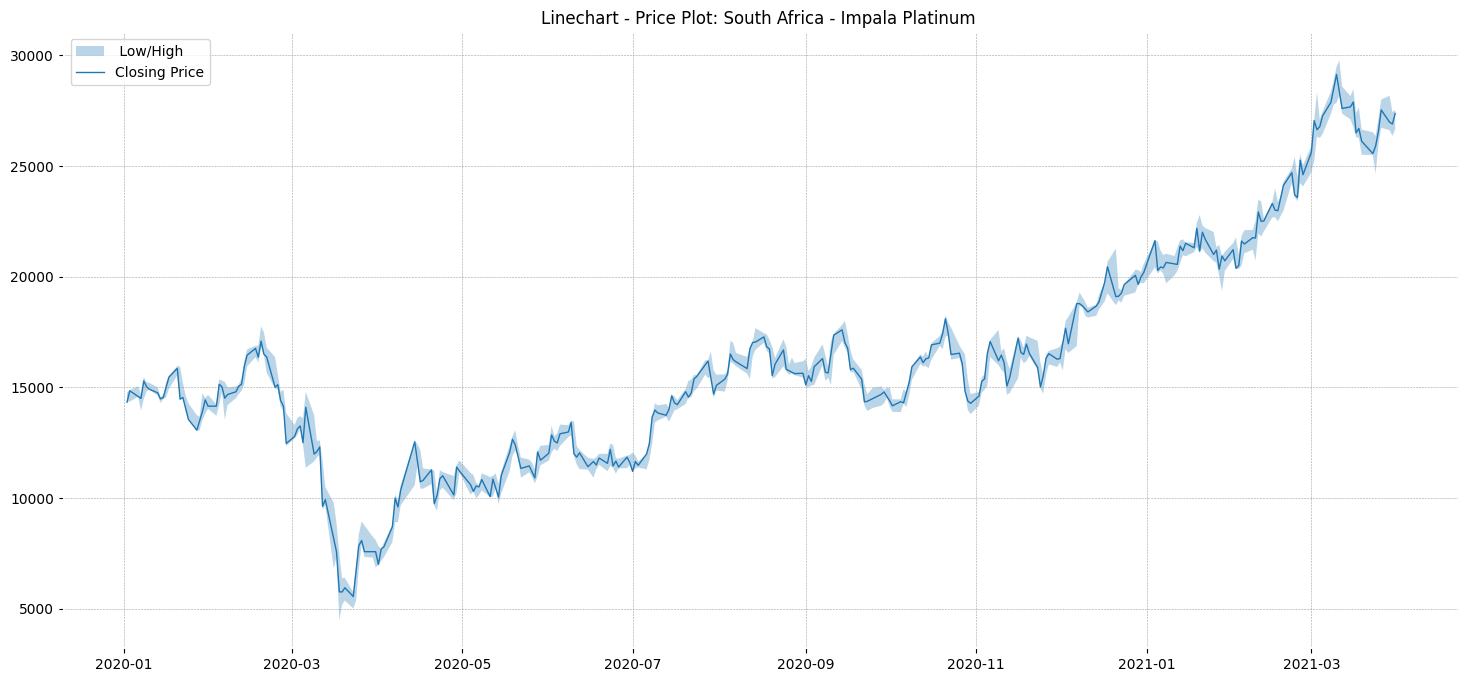

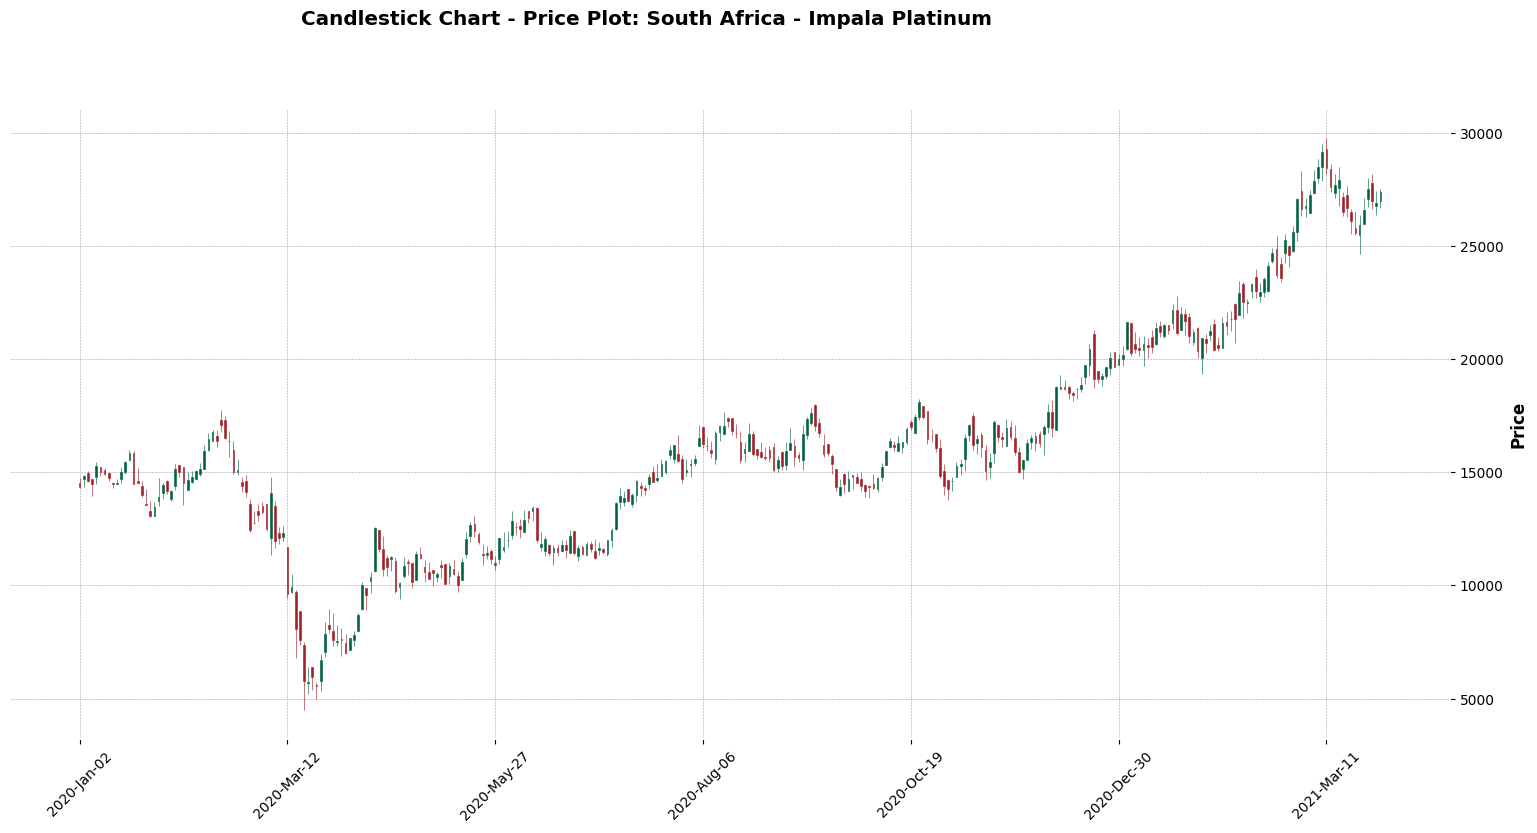

In [102]:
EDA_plot(df_sa,name=company_name[6])

scaled price dataset (314, 1)
scaled tensor (309, 5, 1) (309, 1)
training (197, 5, 1) (197, 1)
validation (50, 5, 1) (50, 1)
test (62, 5, 1) (62, 1)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
7/7 [==============================] - 8s 961ms/step - loss: 0.0938 - root_mean_squared_error: 0.3063 - val_loss: 0.1228 - val_root_mean_squared_error: 0.3504
Epoch 2/50
7/7 [==============================] - 5s 811ms/step - loss: 0.0364 - root_mean_squa

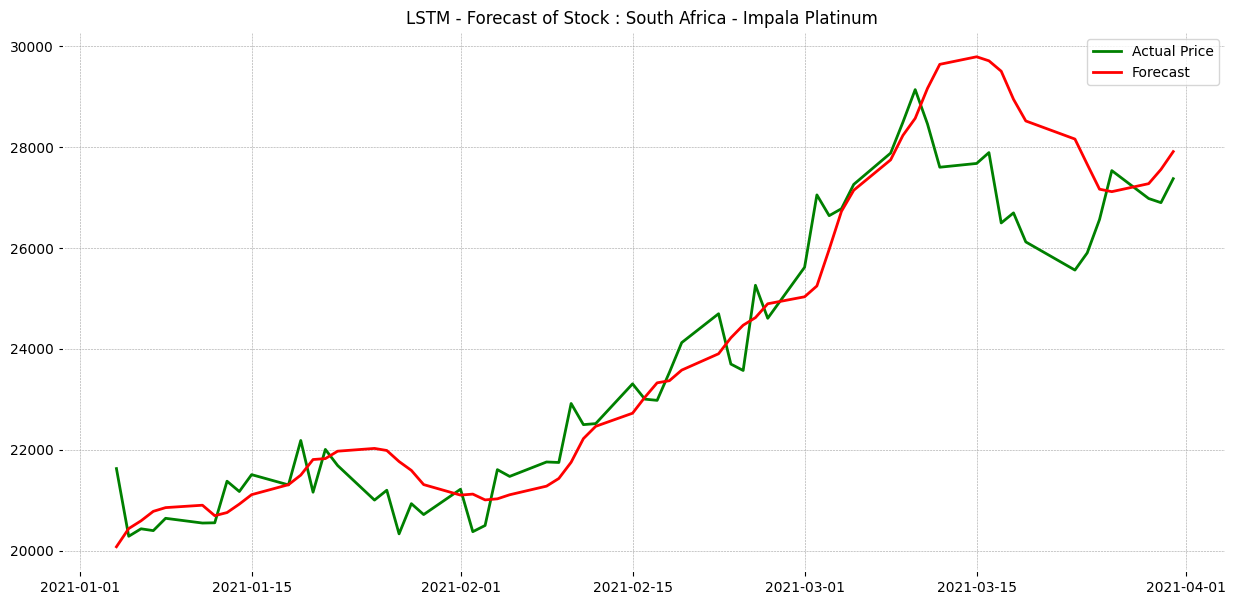

In [103]:
lstm_model_sa, forecast_lstm_sa = lstm(df_sa,name=company_name[6])

2021-01-28 00:00:00: Buy 4.78 stocks @ 20934.00
2021-01-29 00:00:00: Hold stocks
2021-02-01 00:00:00: Hold stocks
2021-02-02 00:00:00: Hold stocks
2021-02-03 00:00:00: Hold stocks
2021-02-04 00:00:00: Hold stocks
2021-02-05 00:00:00: Hold stocks
2021-02-08 00:00:00: Hold stocks
2021-02-09 00:00:00: Hold stocks
2021-02-10 00:00:00: Hold stocks
2021-02-11 00:00:00: Hold stocks
2021-02-12 00:00:00: Hold stocks
2021-02-15 00:00:00: Hold stocks
2021-02-16 00:00:00: Hold stocks
2021-02-17 00:00:00: Hold stocks
2021-02-18 00:00:00: Hold stocks
2021-02-19 00:00:00: Hold stocks
2021-02-22 00:00:00: Hold stocks
2021-02-23 00:00:00: Hold stocks
2021-02-24 00:00:00: Hold stocks
2021-02-25 00:00:00: Hold stocks
2021-02-26 00:00:00: Hold stocks
2021-03-01 00:00:00: Hold stocks
2021-03-02 00:00:00: Hold stocks
2021-03-03 00:00:00: Hold stocks
2021-03-04 00:00:00: Hold stocks
2021-03-05 00:00:00: Sell @ 27260.000000000004
Estimated Returns:130218.78, Estimated Gain/Loss:30218.78
2021-03-19 00:00:00: B

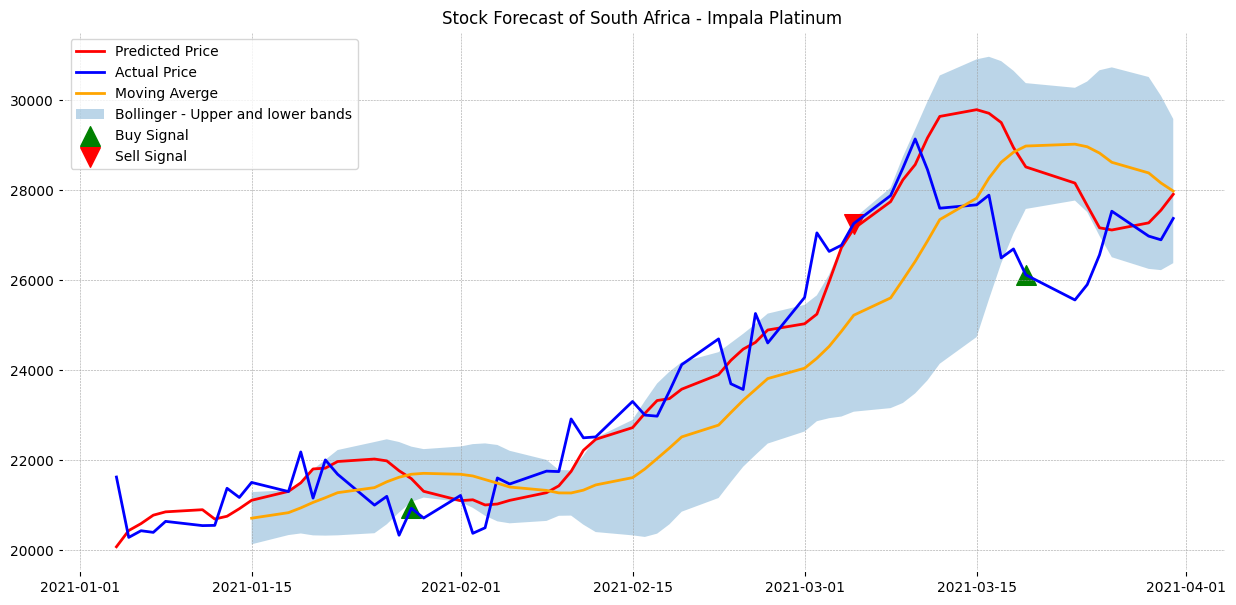

In [245]:
trading_algo(rolling_window=10,forecast=forecast_lstm_sa,stoploss=.1,initial_capital = 100000,LB_threshold = 0.001,max_hold=5,min_margin=0.3,name=company_name[6])

For South Africa's - Impala Platinum Stocks, we have achieved a 30.2% Capital Return, without any losses.

Estimated Returns:130218.78, Estimated Gain/Loss:30218.78

# **South Korea** - Dongkuk Steel Mil

In [105]:
df_dic[company_name[7]].info()
print(df_dic[company_name[7]].tail())

<class 'pandas.core.frame.DataFrame'>
Index: 342 entries, 2021-03-31 00:00:00 to Highest: 14,200
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     342 non-null    object 
 1   Open      342 non-null    object 
 2   High      342 non-null    object 
 3   Low       342 non-null    object 
 4   Vol.      341 non-null    object 
 5   Change %  341 non-null    float64
dtypes: float64(1), object(5)
memory usage: 18.7+ KB
                             Price                Open            High  \
Date                                                                     
2020-01-07 00:00:00           5690                5740            5770   
2020-01-06 00:00:00           5730                5890            5890   
2020-01-03 00:00:00           5900                5870            5920   
2020-01-02 00:00:00           5850                5930            5980   
Highest: 14,200      Lowest: 2,780  Difference: 11,420  Averag

In [106]:
df_sk= ini_preprocess(df_dic[company_name[7]])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 341 entries, 2020-01-02 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     341 non-null    float64
 1   Open      341 non-null    float64
 2   High      341 non-null    float64
 3   Low       341 non-null    float64
 4   Vol.      341 non-null    float64
 5   Change %  341 non-null    float64
dtypes: float64(6)
memory usage: 18.6 KB
              Price     Open     High      Low       Vol.  Change %
Date                                                               
2021-03-26  12200.0  11500.0  12300.0  11350.0  2340000.0    0.0796
2021-03-28  12200.0  12200.0  12200.0  12200.0        0.0    0.0000
2021-03-29  13550.0  12500.0  13800.0  12500.0      200.0    0.1107
2021-03-30  13650.0  13850.0  14200.0  13050.0  3170000.0    0.0074
2021-03-31  13650.0  13700.0  13750.0  13450.0      190.0    0.0000


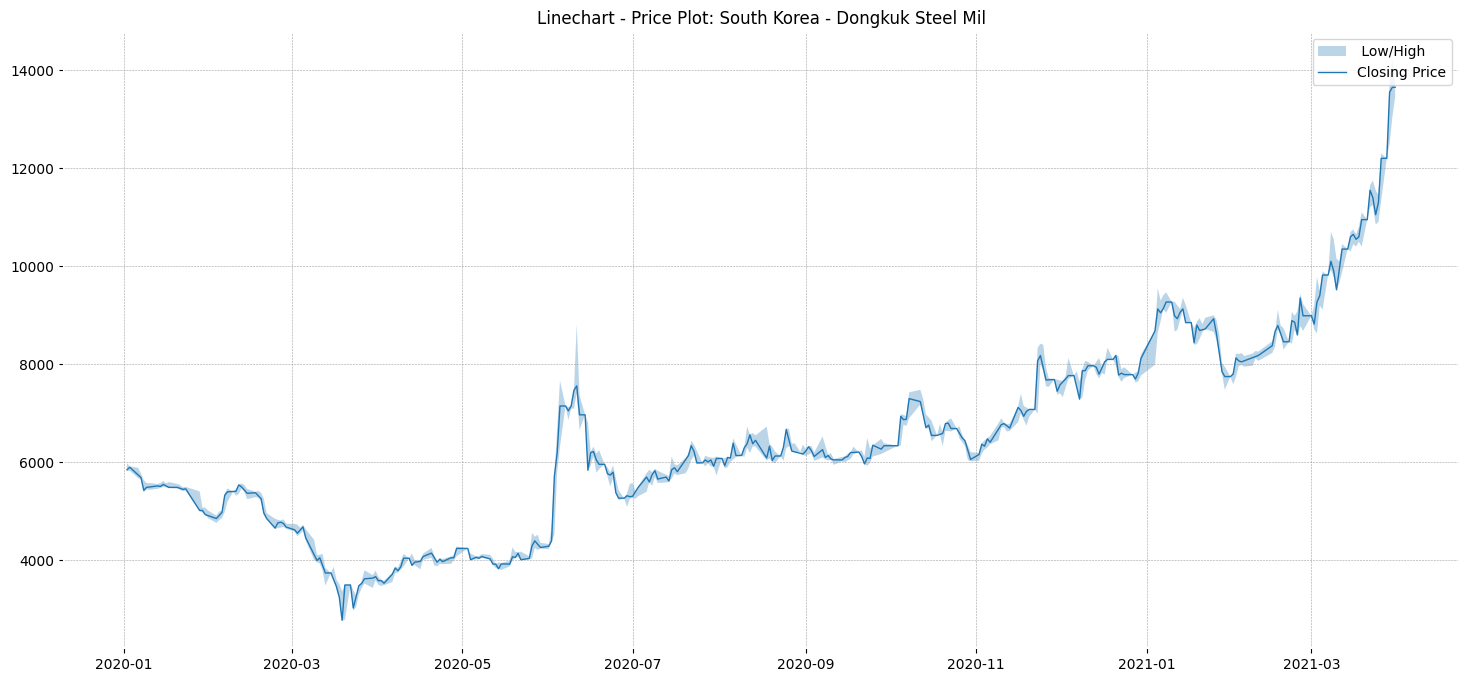

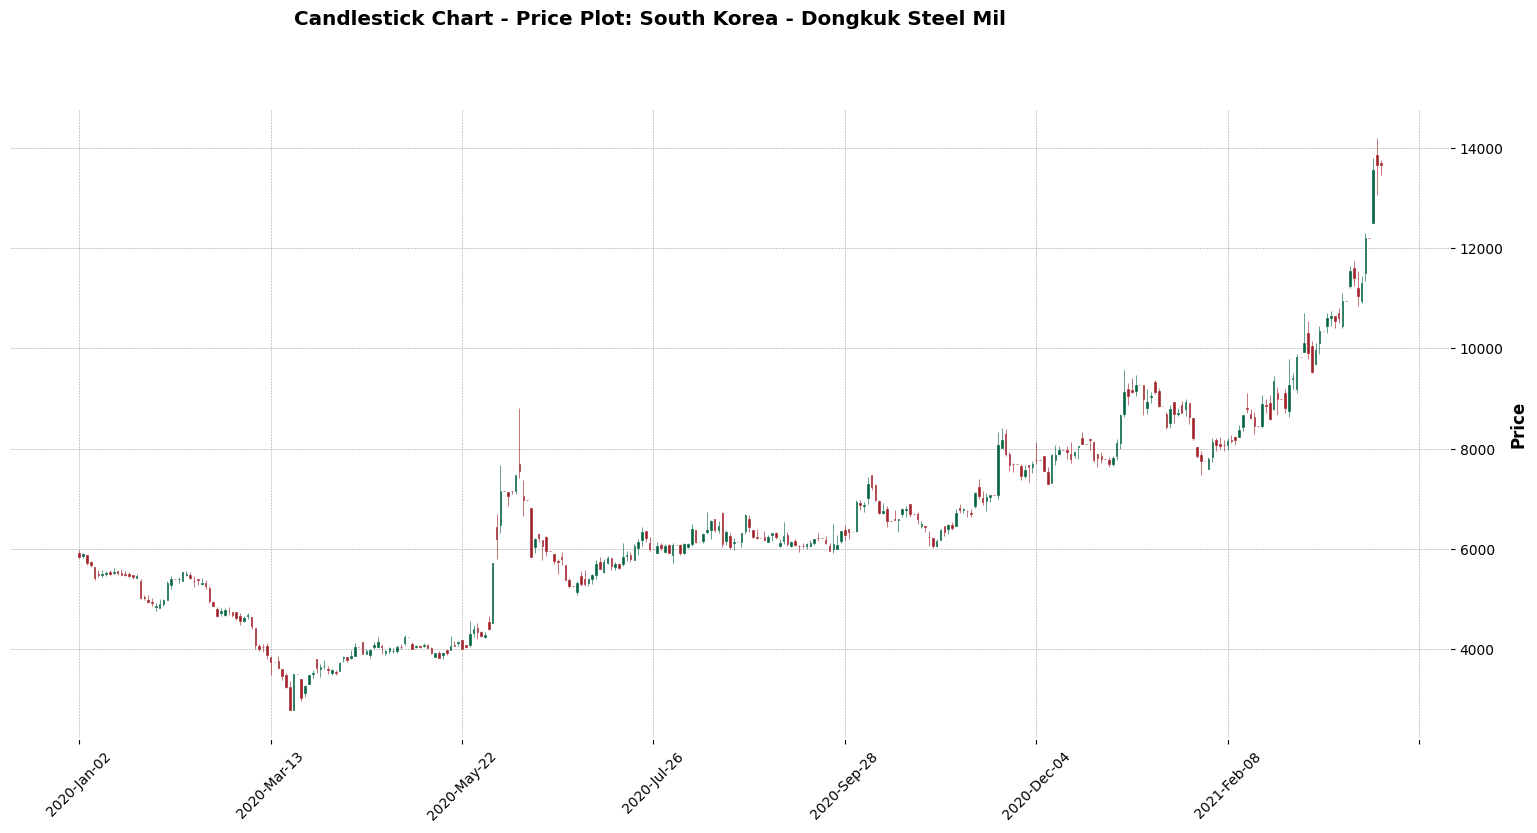

In [107]:
EDA_plot(df_sk,name=company_name[7])

scaled price dataset (341, 1)
scaled tensor (336, 5, 1) (336, 1)
training (213, 5, 1) (213, 1)
validation (54, 5, 1) (54, 1)
test (69, 5, 1) (69, 1)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                16896     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
7/7 [==============================] - 6s 557ms/step - loss: 0.0396 - root_mean_squared_error: 0.1991 - val_loss: 0.0618 - val_root_mean_squared_error: 0.2486
Epoch 2/50
7/7 [==============================] - 3s 481ms/step - loss: 0.0088 - root_mean_squa

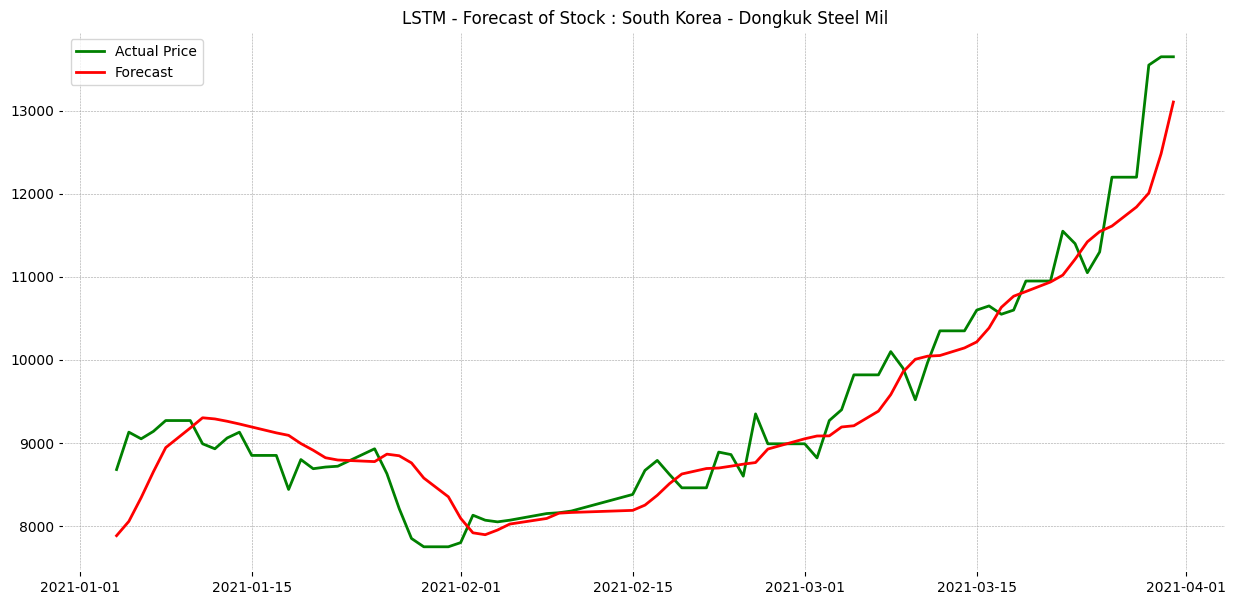

In [108]:
lstm_model_sk, forecast_lstm_sk = lstm(df_sk,name=company_name[7])

2021-01-27 00:00:00: Buy 12.18 stocks @ 8210.00
2021-01-28 00:00:00: Hold stocks
2021-01-29 00:00:00: Hold stocks
2021-01-31 00:00:00: Hold stocks
2021-02-01 00:00:00: Hold stocks
2021-02-02 00:00:00: Hold stocks
2021-02-03 00:00:00: Hold stocks
2021-02-04 00:00:00: Hold stocks
2021-02-05 00:00:00: Hold stocks
2021-02-08 00:00:00: Hold stocks
2021-02-09 00:00:00: Hold stocks
2021-02-10 00:00:00: Hold stocks
2021-02-15 00:00:00: Hold stocks
2021-02-16 00:00:00: Hold stocks
2021-02-17 00:00:00: Hold stocks
2021-02-18 00:00:00: Hold stocks
2021-02-19 00:00:00: Hold stocks
2021-02-21 00:00:00: Hold stocks
2021-02-22 00:00:00: Hold stocks
2021-02-23 00:00:00: Hold stocks
2021-02-24 00:00:00: Hold stocks
2021-02-25 00:00:00: Hold stocks
2021-02-26 00:00:00: Hold stocks
2021-03-01 00:00:00: Hold stocks
2021-03-02 00:00:00: Hold stocks
2021-03-03 00:00:00: Hold stocks
2021-03-04 00:00:00: Hold stocks
2021-03-05 00:00:00: Hold stocks
2021-03-07 00:00:00: Hold stocks
2021-03-08 00:00:00: Hold st

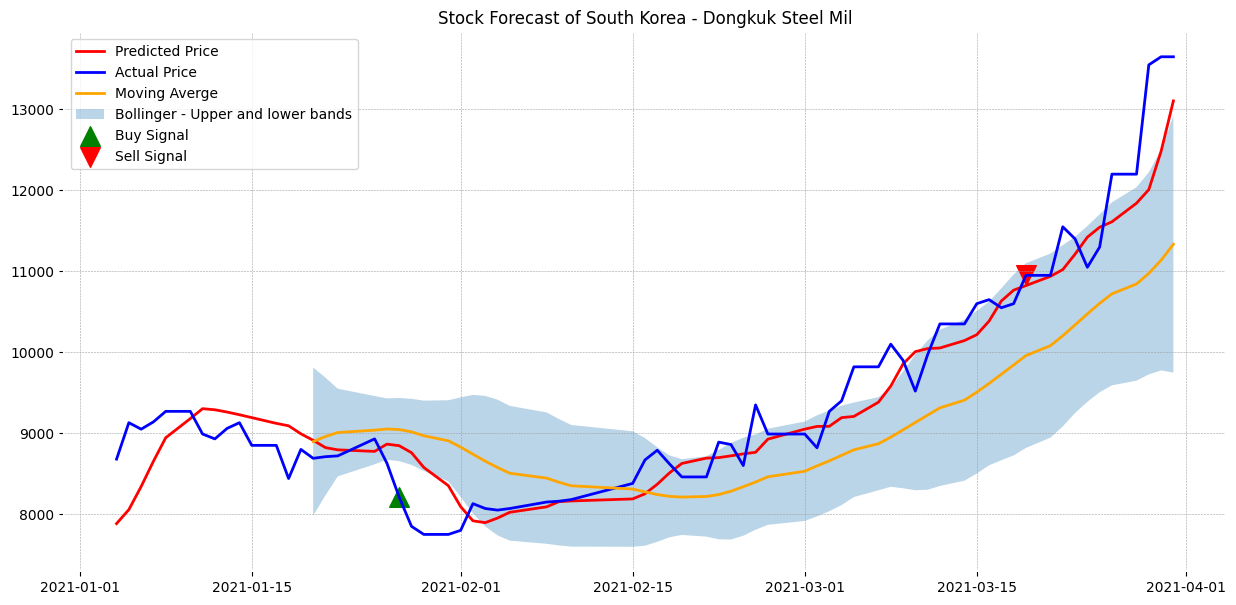

In [196]:
trading_algo(rolling_window=15,forecast=forecast_lstm_sk,stoploss=.1,initial_capital = 100000,LB_threshold = 0.001,max_hold=5,min_margin=0.3,name=company_name[7])

South Korea's - Dongkuk Steel Mil Stocks, we have achieved a 33.4% Capital Return, without any losses.

Estimated Returns:133373.93, Estimated Gain/Loss:33373.93



---



##  By utilizing LSTM for univariate timeseries forecasting in conjunction with the Bollinger Bands strategy, along with customized parameters and special conditional triggers, we have effectively met the project objectives. This approach has resulted in no losses and achieved the maximum possible return on investment.


## **Trading strategy:**

This Trading algorithm is designed to make buy, hold, and sell decisions by leveraging a Bollinger Bands strategy with the goal of maximizing capital returns, minimize losses, and decrease the holding period.

Three additional parameters provide more control over trade decisions, specific conditions are employed to assess the trend. Depending on the forecasted trend, we can adjust the thresholds inorder to ensure maximum returns and minimal losses. For example, a minimum margin parameter of 1% might be applied for a downward trend, while 8-10% could be utilized for an upward trend.


*   For a buy signal, it verifies whether the previous closing price is below the lower Bollinger Band, and the current price is within a specified threshold above the lower Bollinger Band.
*   For a sell signal, it examines whether the current price surpasses the upper Bollinger Band or if the maximum holding period has been reached. Additionally, it checks if the current price is above a minimum margin from the locked price. The inclusion of a Minimum margin is empoyed to ensforce the maximum possible profit.
* The trailing stop feature automatically adjusts the stop-loss mark based on the current price. If the current price falls below a certain percentage of the stop-loss price, a stop-loss trigger is activated. Consequently, stocks are sold, and the available capital is updated, thus minimizing losses.



**Note**: While this trading strategy should reasonably meet our objectives given the limited dataset length and samples, further fine-tuning may be necessary based on the specific dataset. Additionally, integration of supplementary indicators like the Relative Strength Indicator (RSI) and the BandWidth indicator, which complement Bollinger Bands, could be explored for further refinement.



References:


1. https://medium.com/analytics-vidhya/analysis-of-stock-price-predictions-using-lstm-models-f993faa524c4
2. https://medium.com/codex/introduction-to-prophet-algorithm-a59e463a6c72
3. https://medium.com/analytics-vidhya/time-series-forecasting-arima-vs-prophet-5015928e402a
4. https://www.analyticsvidhya.com/blog/2023/06/sarima-model-for-forecasting-currency-exchange-rates/
5. https://neptune.ai/blog/arima-sarima-real-world-time-series-forecasting-guide
6. https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6
7. https://www.investopedia.com/terms/b/bollingerbands.asp
8. https://www.investopedia.com/terms/t/trailingstop.asp
9. https://www.investopedia.com/terms/s/sma.asp

